<a id="top"></a>
# MIRI MRS Spectroscopy of a Late M Star - Detector Based Extraction Technique

**Use case:** This notebook illustrates a spectral extraction technique from detector image plane using a PSF model and the pixel variance. This extraction is considered more advanced than what is currently implemented in the JWST pipeline and is expected to be fully integrated into the pipeline in the future.<br>
**Data:** Simulated [MIRI MRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy) spectrum of AGB star.<br>
**Source of Simulations:** [MIRISim](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)<br>
**Pipeline Version:** [JWST Pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)<br>
**Tools:** jwst, astropy, numpy, scipy.<br>
**Cross-intrument:** No. <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

**Note**: This notebook includes MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public) and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of point sources with spectra representative of late M type stars.

## Introduction

This notebook analyzes one star represented by a dusty SED corresponding to the ISO SWS spectrum of W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns.  Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes.

This is the first notebook, which will process the data and automatically detect and extract spectra for the point source.  The workflow automatically detects sources on the detector image plane to extract the spectrum of the point source. Then it will read in the spectra generated at Stage 3 of the JWST pipeline.

## Motivation to the Detector Based Extraction Technique

At present, one-dimensional spectra produced by the JWST pipeline are
constructed exclusively from the combined and rectified 3-dimensional
data cubes.  These data cubes are treated as a collection of images at
various wavelength planes, and simple aperture-based (or effective
PSF-weighted) techniques are used to recover the source intensity as a
function of wavelength in a manner akin to standard imaging PSF
photometry.  However, this method of extracting point source spectra
from data cubes is not ideal; fundamentally, a source with no spatial
structure should not undergo spatial reprocessing prior to extraction of
spectral information.  Indeed, large-scale IFU surveys targeting point
sources rather than extended sources (e.g., SDSS IV/MaStar, R. Yan et
al. 2019) have relied on detector-based spectral extraction rather than
the construction of 3d data cubes.

For the MIRI MRS in particular, such detector-based extraction offers
the opportunity to correct for the following effects which would be
difficult or impossible to handle once the observational data has been
rectified into 3-dimensional cubes:

1) Given the significant undersampling of the MRS, offsets in spaxel
sampling locations as a function of wavelength can alias spatial
structure from the point spread function into spectral artifacts that
bias extracted 1D spectra.  3D cube building is designed in a manner to
mitigate these artifacts, but the act of resampling ensures that 1D
spectra of unresolved sources extracted from 3D cubes can never be as
reliable as 1D spectra extracted directly from detector-level data
without the intermediate resampling step.

2) Resampled pixels in the data cubes have significant covariance with
adjacent/nearby pixels.  Treating this covariance properly in the
construction of extracted 1D spectra with flux and variance information
is challenging, and not handled at present by the cube-based spectral
extraction.

3) Pipeline calibrations of the instrument throughput and wavelength
calibration are based on sources that fill a given IFU slice, whereas
point sources produce a non-uniform response depending upon the location
of the source centroid within a given IFU slice.  For instance, given
the degeneracy on the detector between the spatial across-slice and
spectral dispersion directions, the wavelength solution for point
sources will differ slightly than for extended sources in a manner that
depends on the source location within the slice.  This effect cannot be
recovered once a 3D cube has been constructed that combines data from
many slices (and indeed, multiple dithered exposures).

4) The MRS has a spectral leak in which 2nd order light from 6 microns
(Ch1B) is visible at a few percent transmission in the 12 micron
observations (Ch3A).  This effect is not possible to correct in general,
since the Ch3A field of view is larger than that of Ch1B.  However, for
the specific case of a point source within the common field of view of
all channels it is possible to use the Ch1B spectrum to predict and
subtract the second-order signal from the Ch3A data.

## Implementation of the Algorithm

In this notebook, we implement a method for achieving MIRI MRS
detector-based point source extraction. The formalism behind the method
follows the optimal spectral extraction formalism by Keith Horne 1986.
Extracting a 1d integrated spectrum directly from the MRS detectors
depends on (a) a detailed knowledge of the detector PSF, and (b) the
pixel variance. The MRS detector PSF differs considerably from the
telescope PSF due to the scattering of the photons inside the detector
substrate. How well the detector PSF is understood/modeled/measured is
key in this instance and should not be understated. For the pixel
variance, the slope-fitting uncertainty from the pixel integration
ramp(s) is used. The combination of the detector PSF and pixel variance
is used as a weighing function to weigh the signal in each detector pixel.

In its most basic form, the notebook code assumes that there is only one
point source in the MRS field of view. Using a Gaussian-fitting routine
at detector-level, the centroid of the point source is determined with a
sub-pixel accuracy. The centroid is used to project the known detector
PSF model directly onto the point source signal. The centroid is also
used to derive the throughput and wavelength correction due to the
location of the point source with respect to the imaging slicer of the
MRS. The throughput and wavelength correction are applied before the
spectral extraction step.

The spectral extraction step integrates the point source flux in a
pre-defined list of wavelength bins. All detector pixels contributing to
a wavelength bin are weighed by the projected PSF model -and- the pixel
variance. In case the extracted spectral band is MRS band 3A (around 12
microns) then the following steps are taken:
- The band 1B (~6 micron) detector image is multiplied by a spectral
leak transmission curve.
- A 1d “spectral leak” integrated point source spectrum is extracted
from band 1B.
- The spectral leak spectrum is subtracted from the band 3A integrated
point source spectrum.

Future improvements to the code will allow users to input MRS point
source centroid locations to address the case of crowded fields, barely
resolved blended point sources, and point sources located within a
semi-extended environment with spatial structure. In addition, the fine
centroiding, currently performed using a Gaussian distribution, can be
improved by striving for residual minimisation with a master
detector-based PSF model. Such a master PSF model will be derived and
refined throughout commissioning and Cycle 1 calibration. 



## Import Packages

In [1]:
# Import useful python packages
import numpy as np
from scipy.interpolate import interp1d

# Import packages to display images in the notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt    
%matplotlib notebook   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18', 
         'axes.titlesize': '18', 'xtick.labelsize': '18', 
         'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_20205/2686257760.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import warnings
warnings.simplefilter('ignore')

In [216]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename
from astropy.utils.data import download_file

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList

# To make nice plots with WCS axis
# import aplpy

# To fit a curve to the data
from scipy.optimize import curve_fit

# To download data
import urllib.request
from pathlib import Path # would move to top with other imports

## Set paths to the Data and Outputs

Use MIRISim JWST pipeline processed data in future iterations.

In [4]:
# import JWST pipeline

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst.extract_1d import Extract1dStep
import json
import glob
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import crds
from jdaviz.app import Application
import asdf
from photutils import aperture_photometry
import os

2022-04-13 13:42:39,325 - stpipe - INFO - Loading settings from /Users/ofox/.glue/settings.cfg


<p style="font-size:200%; color:#e56020; background-color:#1d1160;"><b><i>Reviewer note:</i> Begin PEP8 check cells (delete below when finished)</b></p>

In [5]:
# disable all imported packages' loggers
import logging
logging.root.manager.loggerDict = {}

In [7]:
# enable PEP8 checker for this notebook
%load_ext pycodestyle_magic
%flake8_on --ignore E261,E501,W291,W293

# only allow the checker to throw warnings when there's a violation
logging.getLogger('flake8').setLevel('ERROR')
logging.getLogger('stpipe').setLevel('ERROR')

2022-04-13 13:43:11,510 - stpipe - INFO - 1: E999 SyntaxError: invalid syntax
2022-04-13 13:43:11,512 - stpipe - INFO - 3:13: E225 missing whitespace around operator
2022-04-13 13:43:11,512 - stpipe - INFO - 3:25: E231 missing whitespace after ','
2022-04-13 13:43:11,513 - stpipe - INFO - 3:30: E231 missing whitespace after ','
2022-04-13 13:43:11,514 - stpipe - INFO - 3:35: E231 missing whitespace after ','


<p style="font-size:200%; color:#e56020; background-color:#1d1160;"><b><i>Reviewer note:</i> End PEP8 check cells (delete above when finished)</b></p>

In [239]:
tar_location = Path('./')
tar_files = ['20210413_120546_mirisim.tar.gz', 
             '20210413_123047_mirisim.tar.gz',
             '20210413_125354_mirisim.tar.gz'] # and so on
tar_paths_full = [tar_location / f for f in tar_files]
tar_urls = ['https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_120546_mirisim.tar.gz',
            'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_123047_mirisim.tar.gz',
            'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_125354_mirisim.tar.gz']

for p, url in zip(tar_paths_full, tar_urls):
    # check for un-tarred version of file
    tmp = p.parent / p.stem
    if os.path.exists(tmp.stem):
        print(f"{p.name} Directory Exists.")
    else:
        # check for tarred version of file and un-tar
        if os.path.exists(p):
            tar = tarfile.open(p, "r:gz")
            tar.extractall()
            tar.close()
        # otherwise, download and un-tar file
        else:
            urllib.request.urlretrieve(url, p)
            print(f"Downloading {p.name}...")

20210413_120546_mirisim.tar.gz Directory Exists.
20210413_123047_mirisim.tar.gz Directory Exists.
20210413_125354_mirisim.tar.gz Directory Exists.


In [10]:
# Create Directories If They Don't Exist
if os.path.isdir("./miri_devel/cdp_data/DISTORTION"):
    print("MIRI Referecne File Directory Exists.")
else:
    os.makedirs("./miri_devel/cdp_data/DISTORTION")
    print("Made Directory ./miri_devel/cdp_data/DISTORTION")

MIRI Referecne File Directory Exists.


In [217]:
data_dir = Path('./')
data_paths = ['spectral_leak_transmission.npy',
              'W_Per_spectrum_sws.fit',
              'jwst_miri_photom_0064.fits',
              'jwst_miri_photom_0060.fits',
              'jwst_miri_photom_0052.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2SHORT_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2MEDIUM_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2LONG_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1SHORT_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1MEDIUM_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1LONG_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3SHORT_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3MEDIUM_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3LONG_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4SHORT_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4MEDIUM_PSF_07.02.00.fits',
              'miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4LONG_PSF_07.02.00.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.03.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.02.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_8B.05.02.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_8B.05.03.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_8B.05.02.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_8B.05.03.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_8B.05.02.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_8B.05.02.fits',
              'miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_8B.05.02.fits']
data_paths_full = [data_dir / p for p in data_paths]
data_urls = ['https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/spectral_leak_transmission.npy',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/W_Per_spectrum_sws.fit',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0064.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0060.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0052.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2SHORT_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2MEDIUM_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_2LONG_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1SHORT_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1MEDIUM_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1LONG_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3SHORT_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3MEDIUM_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_3LONG_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4SHORT_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4MEDIUM_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/MIRI_FM_MIRIFULONG_4LONG_PSF_07.02.00.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.03.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.02.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_8B.05.02.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_8B.05.03.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_8B.05.02.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_8B.05.03.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_8B.05.02.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_8B.05.02.fits',
             'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri_devel/cdp_data/DISTORTION/MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_8B.05.02.fits'] 

for p, url in zip(data_paths_full, data_urls):
    if os.path.exists(p):
        print(f"{p.name} exists.")
    else:
        urllib.request.urlretrieve(url, p)
        print(f"Downloading {p.name}...")

spectral_leak_transmission.npy exists.
W_Per_spectrum_sws.fit exists.
jwst_miri_photom_0064.fits exists.
jwst_miri_photom_0060.fits exists.
jwst_miri_photom_0052.fits exists.
MIRI_FM_MIRIFUSHORT_2SHORT_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFUSHORT_2MEDIUM_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFUSHORT_2LONG_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFUSHORT_1SHORT_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFUSHORT_1MEDIUM_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFUSHORT_1LONG_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_3SHORT_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_3MEDIUM_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_3LONG_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_4SHORT_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_4MEDIUM_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_4LONG_PSF_07.02.00.fits exists.
MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.03.fits exists.
MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B.05.02.fits exists.
MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_8B.05.02.fits exists.
MIRI_FM_MIRIFULO

## Run Pipeline

The various [stages of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html#pipelines) can be [run within Python](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#running-from-within-python).  For a more in depth tutorial on running the pipelines, check out the [JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars).

In [17]:
# Execute calwebb_detector1 pipeline on raw simulation output.  This will overwrite previous reductions.

allshortfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFUSHORT*fits')
alllongfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFULONG*fits')
      
pipe1short = Detector1Pipeline()

# run calwebb_detector1 on the MIRIFUSHORT data separate from MIRIFULONG data, as it saves time this way
for shortfile in allshortfiles:
    print(shortfile)
    baseshort, remaindershort = shortfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestuffshort, dateafterstuffshort = shortfile.split('20210413_')    
    datestringshort, afterstuffshort = dateafterstuffshort.split('_mirisim')
    
    pipe1short.refpix.skip = True
    pipe1short.output_file = baseshort + datestringshort
    
    pipe1short.run(shortfile)

pipe1long = Detector1Pipeline()

for longfile in alllongfiles:
    print(longfile)
    baselong, remainderlong = longfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestufflong, dateafterstufflong = longfile.split('20210413_')
    datestringlong, afterstufflong = dateafterstufflong.split('_mirisim')
    
    pipe1long.refpix.skip = True
    pipe1long.output_file = baselong + datestringlong
    
    pipe1long.run(longfile)

20210413_125354_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12LONGexp1.fits
20210413_125354_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12LONGexp1.fits
20210413_123047_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_123047_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits
20210413_120546_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits
20210413_120546_mirisim/det_images/det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits
20210413_125354_mirisim/det_images/det_image_seq1_MI

In [18]:
# Execute calwebb_spec2 pipeline. This will overwrite previous reductions.

# All the local calwebb_detector1 files
allshortfiles2 = glob.glob('det_image_*_MIRIFUSHORT_*_rate.fits')
alllongfiles2 = glob.glob('det_image_*_MIRIFULONG_*_rate.fits')

for short2file in allshortfiles2:
    print(short2file)
    pipe2short = Spec2Pipeline()
    base2short, remainder2short = short2file.split('.')
    
    pipe2short.straylight.skip = True
    
    # If you run your own simulations, you will need to update these hardcoded files.
    if (short2file == 'det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2short.cube_build.skip = True
    pipe2short.extract_1d.skip = True
    pipe2short.output_file = base2short
        
    pipe2short.run(short2file)

for long2file in alllongfiles2:
    print(long2file)
    pipe2long = Spec2Pipeline()
    base2long, remainder2long = long2file.split('.')
    
    pipe2long.straylight.skip = True
    # If you run your own simulations, you will need to update these hardcoded files.
    if (long2file == 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2long.cube_build.skip = True
    pipe2long.extract_1d.skip = True
    pipe2long.output_file = base2long
    
    pipe2long.run(long2file)

det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq3_MIRIFUSHORT_12LONGexp1125354_rate.fits
det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq2_MIRIFUSHORT_12LONGexp1125354_rate.fits
det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits
this one will have the level 2b cube built
det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits
det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits
det_image_seq4_MIRIFUSHORT_12LONGexp1125354_rate.fits
det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_rate.fits
det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits
det_image_seq3_MIRIFULONG_34ME


 Number of sources in field:  9
peak pixel x =
21.015100846693926
peak pixel y =
22.64385180753751


<IPython.core.display.Javascript object>


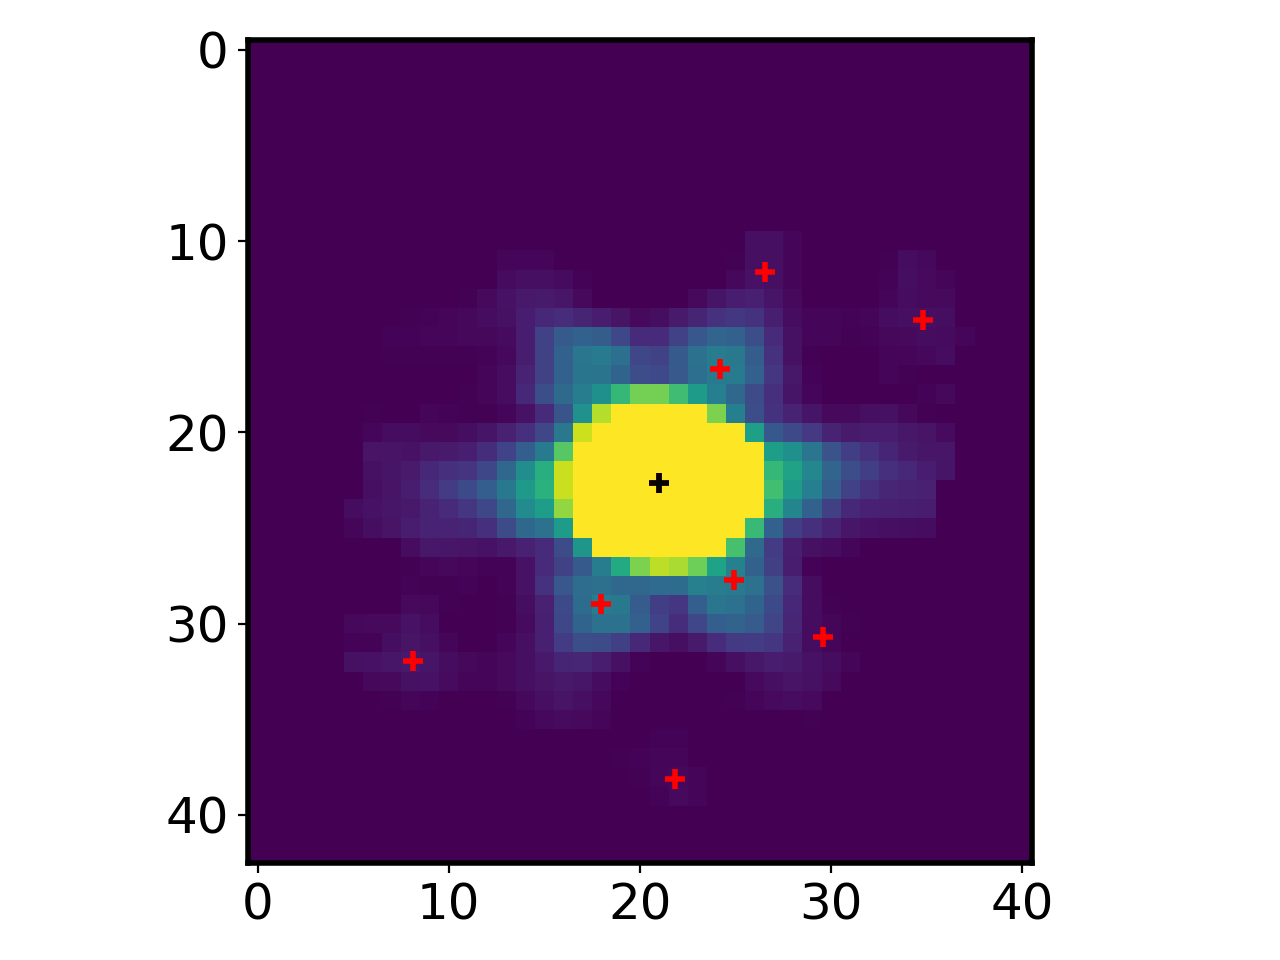

In [29]:
# If you run your own simulations, you will need to update these hardcoded files.
l_cube_file = 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_s3d.fits'
s_cube_file = 'det_image_seq1_MIRIFUSHORT_12LONGexp1125354_s3d.fits'

with fits.open(s_cube_file) as hdu_s_cube:
    s_cube = hdu_s_cube['SCI'].data
    s_med_cube = np.zeros((s_cube.shape[1], s_cube.shape[2]))
    for a in range(s_cube.shape[1]):
        for b in range(s_cube.shape[2]):
            s_med_cube[a, b] = np.median(s_cube[:, a, b])

mean, median, std = sigma_clipped_stats(s_med_cube, sigma=2.0)

# Get a list of sources using a dedicated source detection algorithm
# Find sources at least 3* background (typically)

daofind = DAOStarFinder(fwhm=2.0, threshold=3.*std)
sources = daofind(s_med_cube-median) 
print("\n Number of sources in field: ", len(sources))

# Positions in pixels
positions = Table([sources['xcentroid'], sources['ycentroid']])

# Convert to RA & Dec (ICRS)
peakpixval = np.zeros(len(sources['xcentroid']))
for count_s, _ in enumerate(sources):
    peakpixval[count_s] = s_med_cube[int(np.round(sources['xcentroid'][count_s])), int(np.round(sources['ycentroid'][count_s]))]
print('peak pixel x =')
print(sources['xcentroid'][np.argmax(peakpixval)])
print('peak pixel y =')
print(sources['ycentroid'][np.argmax(peakpixval)])

plt.imshow(s_med_cube, vmin=0, vmax=100)
plt.tight_layout()
plt.scatter(sources['xcentroid'], sources['ycentroid'], c="red", marker="+", s=50)
plt.scatter(sources['xcentroid'][np.argmax(peakpixval)], sources['ycentroid'][np.argmax(peakpixval)], c='black', marker='+', s=50)
plt.show()

f0 = fits.open(s_cube_file)
w0 = WCS(f0[('sci', 1)].header, f0)
f0.close()

radec = w0.all_pix2world([sources['xcentroid'][np.argmax(peakpixval)]], [sources['ycentroid'][np.argmax(peakpixval)]], [1], 1)

# Take the brightest source flux and take that to be your primary point source for extraction
ra_ptsrc = radec[0][0]
dec_ptsrc = radec[1][0]

In [31]:
# Due to the way the pipeline currently extracts Level3 data, you must update the headers to be centered on the point source of your choosing from the step above.
all_files = glob.glob('det_image_*_cal.fits')
targra = ra_ptsrc
targdec = dec_ptsrc
for thisfile in all_files:
    base, remainder = thisfile.split('.')
    outfilename = base + '_fix.' + remainder
    print(outfilename)
    
    with fits.open(thisfile) as hduthis:
        hduthis['SCI'].header['SRCTYPE'] = 'POINT'
        hduthis[0].header['TARG_RA'] = targra 
        hduthis[0].header['TARG_DEC'] = targdec
        hduthis.writeto(outfilename, overwrite=True)

det_image_seq3_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq2_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq1_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_cal_fix.fits
det_image_seq4_MIRIFULONG_34SHORTexp1120546_cal_fix.fits
det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_cal_fix.fits
det_image_seq3_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq4_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq2_MIRIFULONG_34LONGexp1125354_cal_fix.fits
det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_cal_fix.fits
det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_cal_fix.fits
det_image_seq1_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq3_MIRIFUSHORT_12LONGexp1125354_cal_fix.fits
det_image_seq2_MIRIFUSHORT_

In [32]:
# set up needed reference file(s) for spec3

file_all_list = glob.glob('det_image_*_cal.fits')

asnall = asn_from_list.asn_from_list(file_all_list, rule=DMS_Level3_Base, product_name='combine_dithers_all_exposures')

asnallfile = 'for_spec3_all.json'
with open(asnallfile, 'w') as fpall:
    fpall.write(asnall.dump()[1])

In [33]:
# Execute calwebb_spec3 pipeline.  This will overwrite previous reductions.

pipe3ss = Spec3Pipeline()
pipe3ss.master_background.skip = True
pipe3ss.mrs_imatch.skip = True
pipe3ss.outlier_detection.skip = True
pipe3ss.resample_spec.skip = True
pipe3ss.combine_1d.skip = True
pipe3ss.use_source_posn = 'True'
pipe3ss.subtract_background = 'True'
pipe3ss.output_file = 'allspec3'
pipe3ss.run(asnallfile)

## Now to detect the point source in the detector image plane and extract and plot the spectra for each source
Steps involved:
1. Convert MJy/sr to Jy
2. Determine PSF centroid on the detector plane, if this one is not provided
3. Based on the across-slice position of the point source, determine the transmission and wavelength correction factors and apply correction
4. Project MRS PSF model from 3D spectral cube to 2D detector image plane
5. Determine pixel weights based on PSF and pixel variance information
6. Perform detector-based spectral extraction
7. If MRS spectral band is 3A (~12.2 micron), determine diffraction grating second order spectral leak contribution (from ~6.1 microns) and apply correction.

In [34]:
# centroid placeholders in local MRS coordinates
alpha_centers2D_dict = {}
beta_centers2D_dict = {}
# spectrum placeholder
isolambda_spec_optimal = {}

In [36]:
# define spectral band
band = '1B'
ch = band[0]

if ch in ['1', '2']:
    det_id = 'MIRIFUSHORT'
    band_combo = '12'
elif ch in ['3', '4']:
    det_id = 'MIRIFULONG'
    band_combo = '34'
    
if band[1] == 'A':
    band_id = 'short'
    band_id_nr = 1
elif band[1] == 'B':
    band_id = 'medium'
    band_id_nr = 2
elif band[1] == 'C':
    band_id = 'long'
    band_id_nr = 3

In [40]:
# load data file SCI and ERR extensions
if band in ['1A', '2A']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_cal.fits')
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0052.fits', cache=False)
    hdu_photom = fits.open(fn)  
elif band in ['1B', '2B']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits')
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0064.fits', cache=False)
    hdu_photom = fits.open(fn)
elif band in ['1C', '2C']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12LONGexp1125354_cal.fits')
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/jwst_miri_photom_0060.fits', cache=False)
    hdu_photom = fits.open(fn)
sci_img = hdu['SCI'].data
err_img = hdu['ERR'].data

# load photom PIXSIZ extension to convert MJy/sr to Jansky
pixsiz_img = hdu_photom['PIXSIZ'].data

# convert MJy/sr to Jansky for both the SCI and ERR extensions
sci_img = sci_img*pixsiz_img # MJy/sr --> MJy
err_img = err_img*pixsiz_img # MJy/sr --> MJy

sci_img = sci_img*10**6 # MJy --> Jy
err_img = err_img*10**6 # MJy --> Jy

# close opened fits files
hdu.close()
hdu_photom.close()

# Point source corrections CDP values
# Transmission vs across-slice correction
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/miri-ifuptcor-59645.fits', cache=False)
hdu = fits.open(fn)
list_channels = ['CH1', 'CH2', 'CH3', 'CH4']
lamb_min = np.round(hdu['TRACOR'].data['WAVE_MIN'], 2)
lamb_max = np.round(hdu['TRACOR'].data['WAVE_MAX'], 2)
Tcen_min = np.round(hdu['TRACOR'].data['T_WMIN_CENTRE'], 2)
Tcen_max = np.round(hdu['TRACOR'].data['T_WMAX_CENTRE'], 2)
Tedg_min = np.round(hdu['TRACOR'].data['T_WMIN_EDGE'], 2)
Tedg_max = np.round(hdu['TRACOR'].data['T_WMAX_EDGE'], 2)

# Wavelength offset vs across-slice correction
bands = hdu['WAVCORR_OPTICAL'].data['SUB_BAND']
x_slice_min_LT = np.round(hdu['WAVCORR_XSLICE'].data['XSLICE_MIN'][0], 8) # micron * arcsec^-1
x_slice_max_LT = np.round(hdu['WAVCORR_XSLICE'].data['XSLICE_MAX'][0], 8) # micron * arcsec^-1

beta_slice = np.round(hdu['WAVCORR_OPTICAL'].data['BETA_SLICE'], 3)

wave_min = np.round(hdu['WAVCORR_OPTICAL'].data['WAVE_MIN'], 2)
wave_max = np.round(hdu['WAVCORR_OPTICAL'].data['WAVE_MAX'], 2)
srp_min = hdu['WAVCORR_OPTICAL'].data['SRP_MIN']
srp_max = hdu['WAVCORR_OPTICAL'].data['SRP_MAX']

beta_off = np.round(hdu['WAVCORR_SHIFT'].data['BETA_OFF'], 3)
Delta_s_min_LT = hdu['WAVCORR_SHIFT'].data['DS_MIN']
Delta_s_max_LT = hdu['WAVCORR_SHIFT'].data['DS_MAX']

# Spectral leak (second order spectral response in form of an optical system transmission)
sys_transm_img = hdu['SCI'].data
hdu.close()

In [149]:
# import necessary functions from PointSourceDetectorBasedExtractionFuncs and create_distortionMaps
from PointSourceDetectorBasedExtractionFuncs import mrs_aux, point_source_centroiding, evaluate_psf_cdp

# evaluate distortion maps on the 2D detector image plane
from create_distortionMaps import d2cMapping

In [150]:
# define path to distortion (D2C) files (and create folder if it doesn't exist)
workDir = './miri_devel/'
cdpDir = workDir+'cdp_data/'
d2cDir = cdpDir+'DISTORTION/'

# Evaluate largest distortion solution on the 2D detector (lowest slice transmission)
d2cMaps = d2cMapping(band, d2cDir, slice_transmission='10pc', fileversion="8B.05.02")
sliceMap = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
betaMap = d2cMaps['betaMap']
nslices = d2cMaps['nslices']

# some auxiliary data
det_dims = (1024, 1032)
bandlims = [lambdaMap[np.nonzero(lambdaMap)].min(), lambdaMap[np.nonzero(lambdaMap)].max()]

# spectral grid based on which the point source centroid is determined
lambmin = mrs_aux(band)[3][0]
lambmax = mrs_aux(band)[3][1]
lambcens = np.arange(lambmin, lambmax, (lambmax-lambmin)/1024.)
lambfwhms = np.ones(len(lambcens))*(5*(lambmax-lambmin)/1024.)

In [151]:
# Determine point source centroid
sign_amp2D, alpha_centers2D, beta_centers2D, sigma_alpha2D, sigma_beta2D, bkg_amp2D = point_source_centroiding(band, sci_img, d2cMaps, spec_grid=[lambcens, lambfwhms], fit='2D')

alpha_centers2D_dict[band] = alpha_centers2D
beta_centers2D_dict[band] = beta_centers2D

STEP 1: Rough centroiding
Slice 13 has the largest summed flux
Source position: beta = 0.35arcsec, alpha = -0.07arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[]
[Across-slice fit] The following bins failed to converge:
[]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[]


<IPython.core.display.Javascript object>


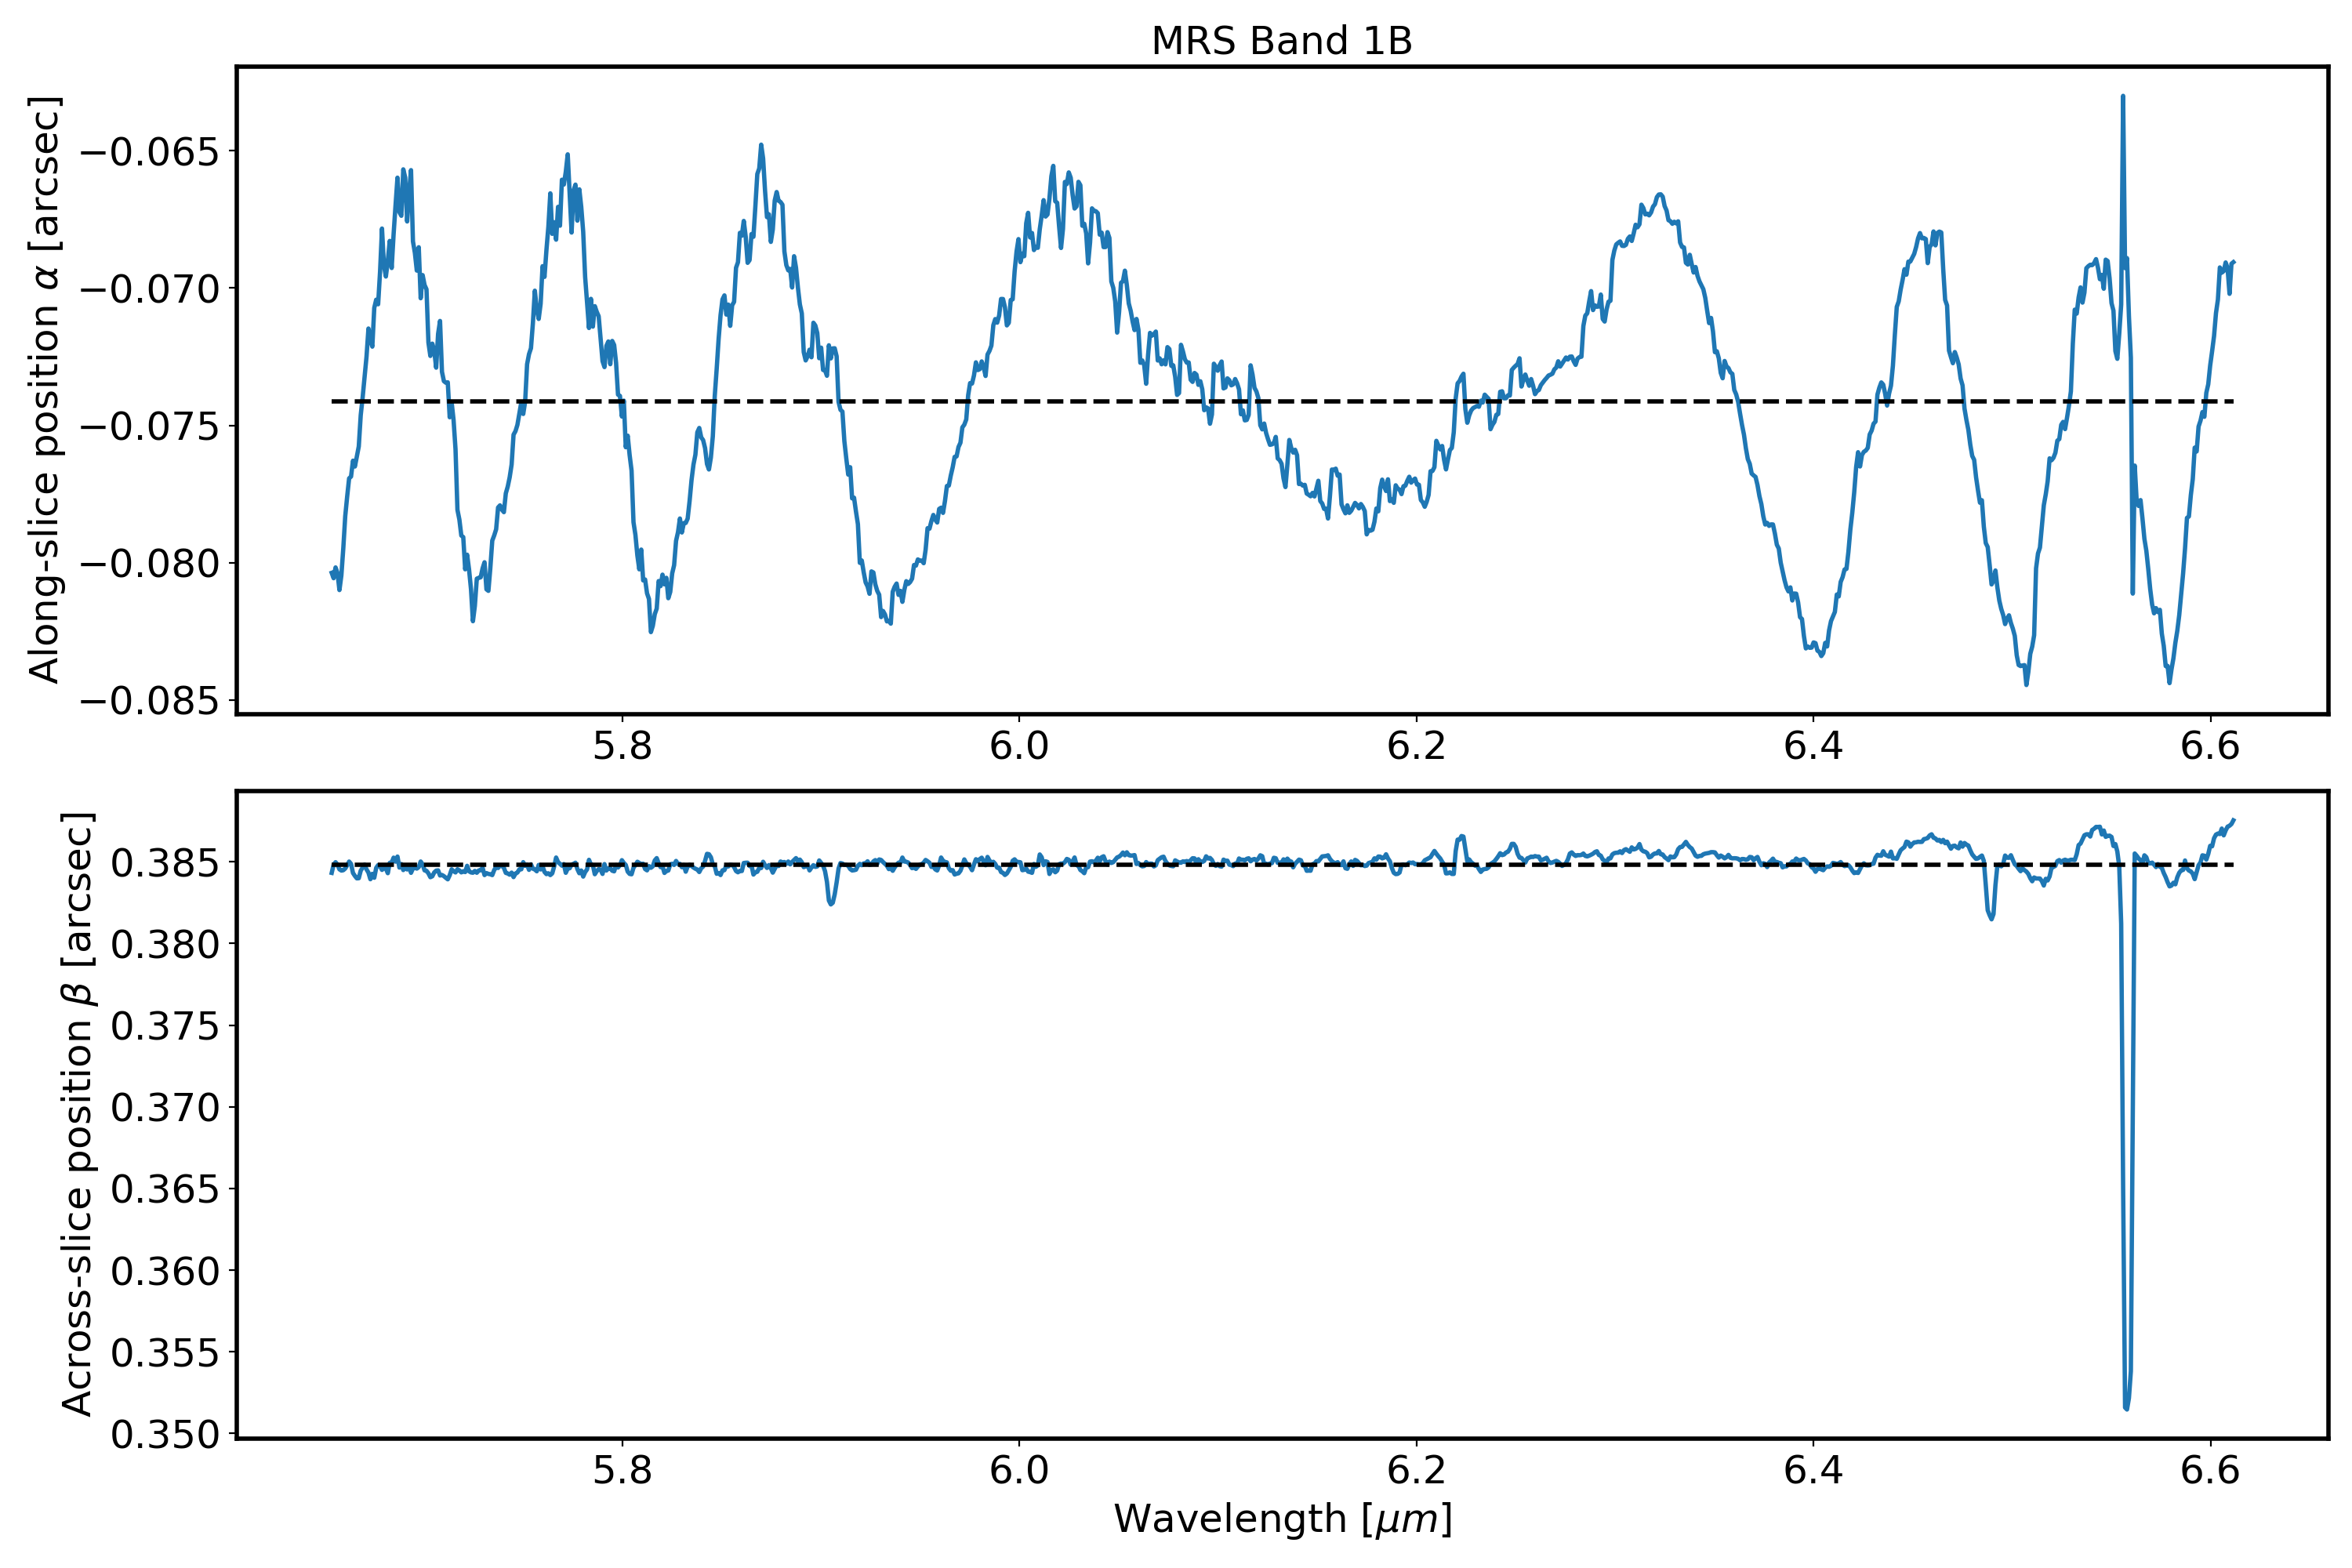

In [152]:
# Diagnostic plot for the point source centroid: We care about the mean value of alpha, beta. These will be used for the PSF projection on the detector plane.
# Conceivably a PSF residual algorithm could be coded, to determine the alpha,beta centroid more accurately still.
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(lambcens[20:-20], alpha_centers2D_dict[band][20:-20])
axs[0].plot(lambcens[20:-20], np.ones(len(lambcens[20:-20]))*np.mean(alpha_centers2D_dict[band][20:-20]), 'k--')
axs[1].plot(lambcens[20:-20], beta_centers2D_dict[band][20:-20])
axs[1].plot(lambcens[20:-20], np.ones(len(lambcens[20:-20]))*np.mean(beta_centers2D_dict[band][20:-20]), 'k--')
axs[0].set_ylabel(r'Along-slice position $\alpha$ [arcsec]')
axs[0].set_title('MRS Band {}'.format(band))
axs[1].set_xlabel(r'Wavelength [$\mu m$]')
axs[1].set_ylabel(r'Across-slice position $\beta$ [arcsec]')
plt.tight_layout()

# Determine transmission factor corresponding to source across-slice position $\beta$, the signal should be multiplied by this factor

In [153]:
beta = np.mean(beta_centers2D_dict[band][20:-20])
wav_array = {}
Tb_min = {}
Tb_max = {}
Tdiff_point = {}
Tdiff_extended = {}
for i, key in enumerate(['CH1', 'CH2', 'CH3', 'CH4']):
    wav_array[key] = np.arange(lamb_min[i], lamb_max[i], 0.01) # micron
    Tb_min[key] = Tcen_min[i] + 2 * abs(beta) * (Tedg_min[i]-Tcen_min[i])
    Tb_max[key] = Tcen_max[i] + 2 * abs(beta) * (Tedg_max[i]-Tcen_max[i])
    
    Tdiff_point[key] = Tb_min[key] + ((wav_array[key]-lamb_min[i])/(lamb_max[i]-lamb_min[i])) * (Tb_max[key]-Tb_min[key])
    Tdiff_extended[key] = (Tcen_min[i]+Tedg_max[i])/2. + ((wav_array[key]-lamb_min[i])/(lamb_max[i]-lamb_min[i])) * ((Tcen_max[i]+Tedg_max[i]) - (Tcen_min[i]+Tedg_min[i])) / 2.

<IPython.core.display.Javascript object>


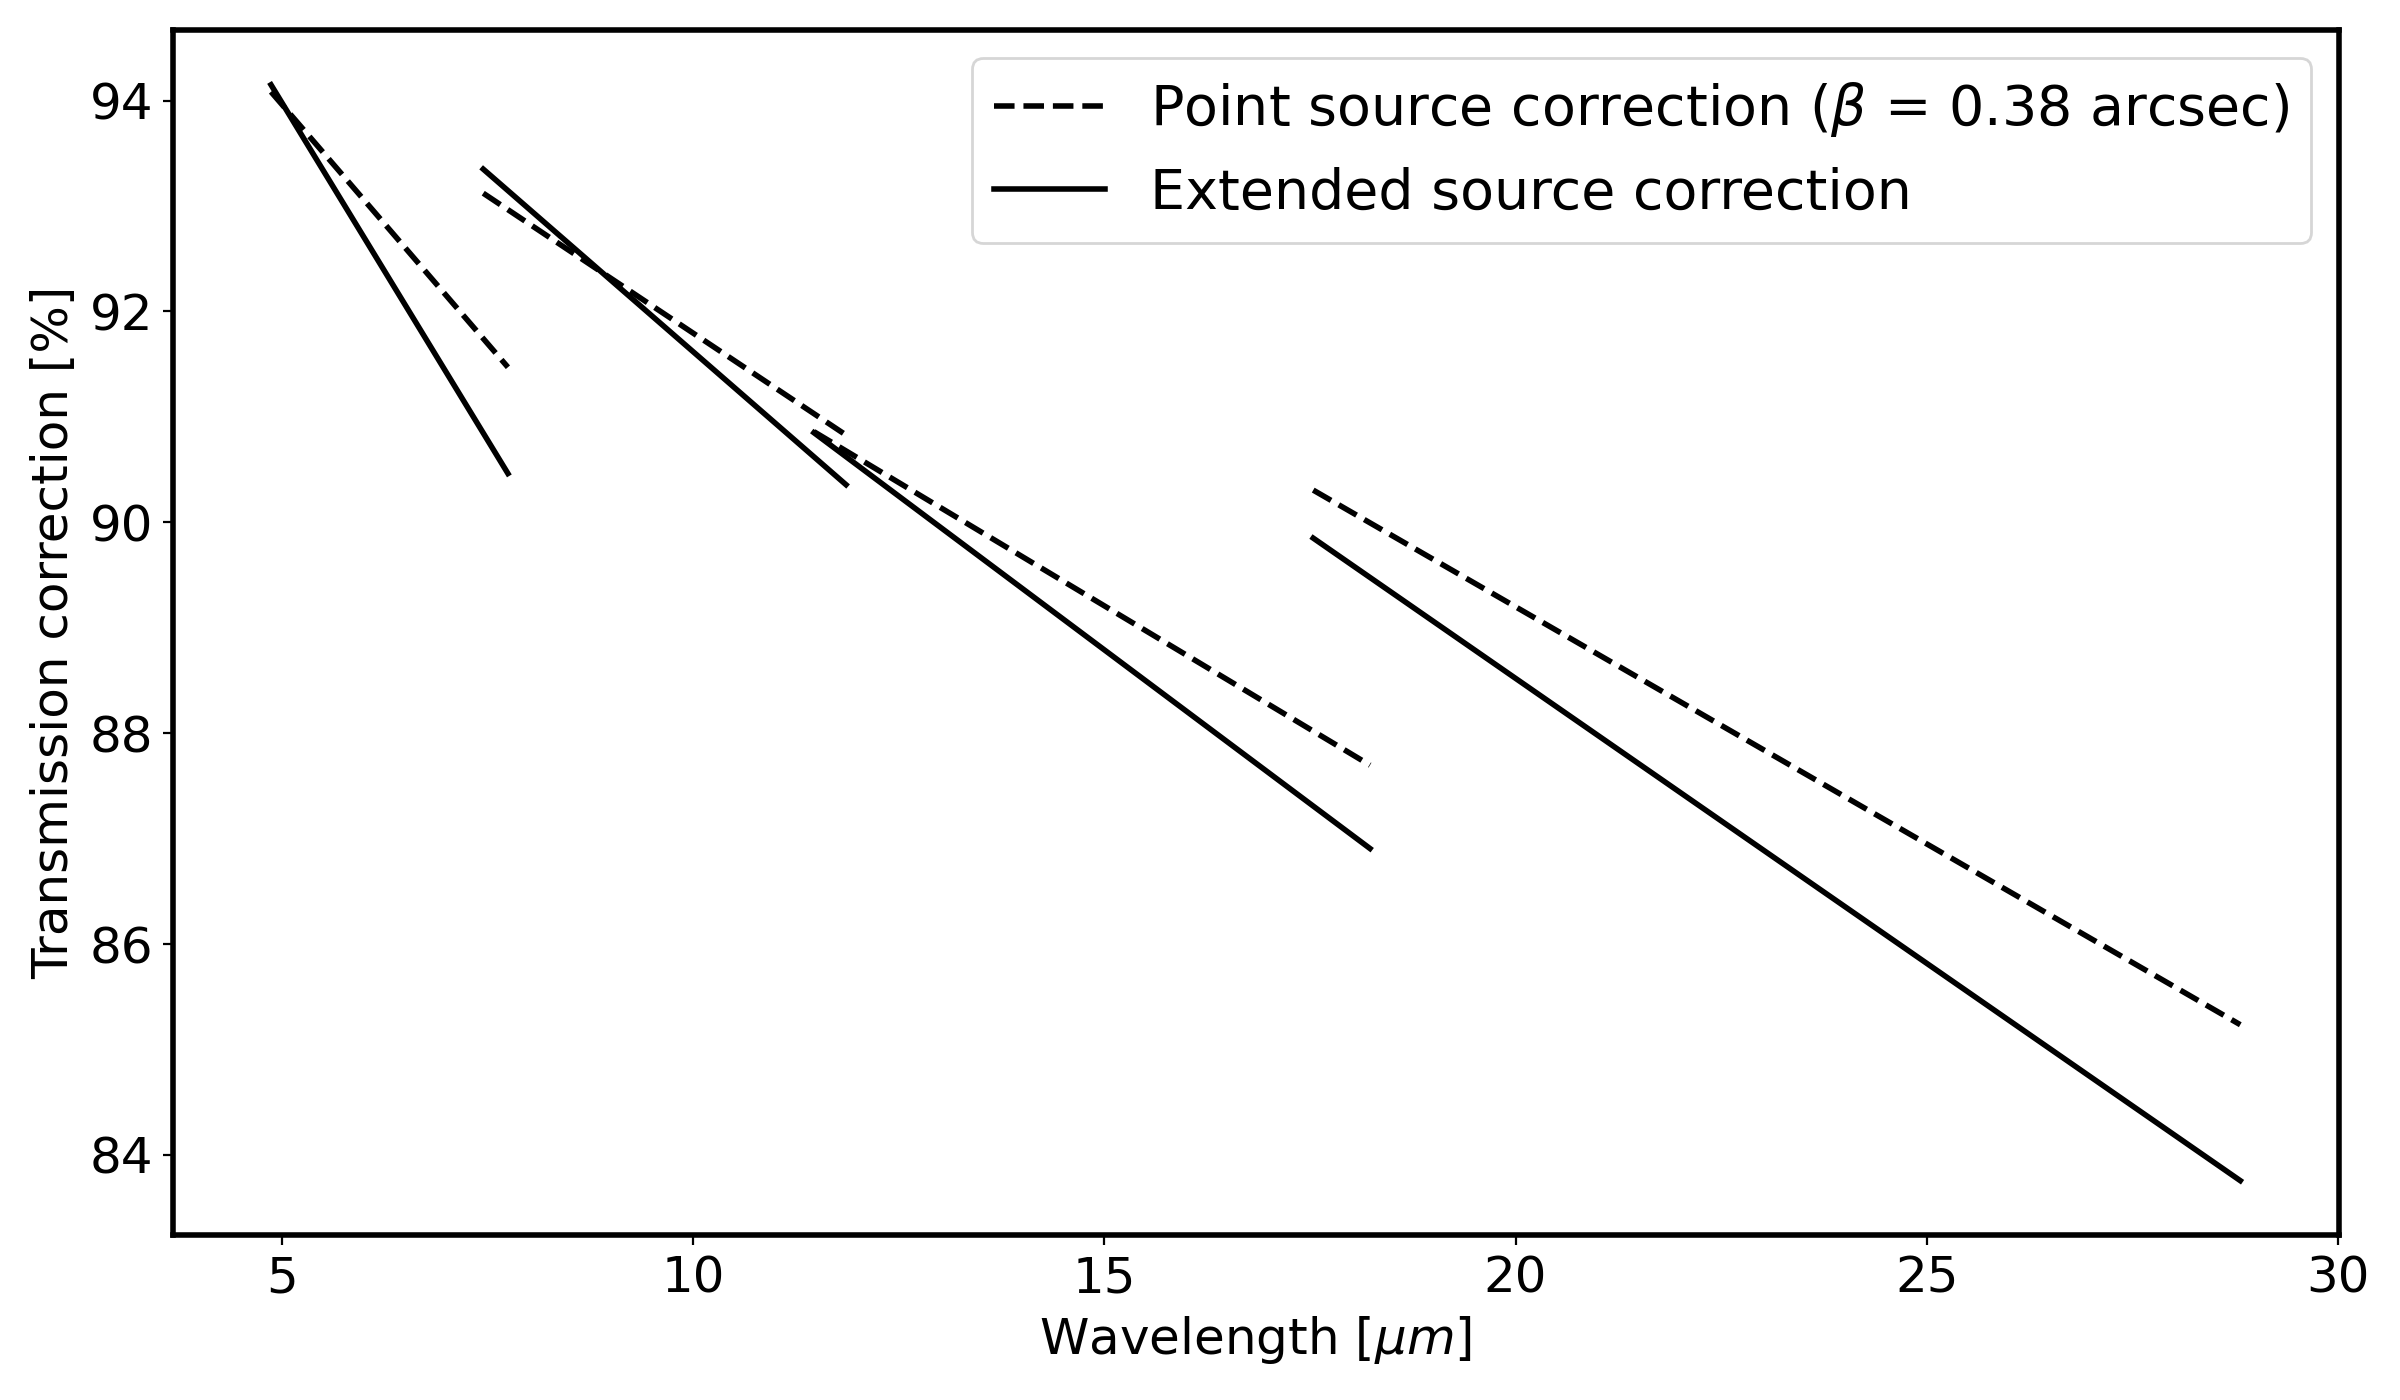

<IPython.core.display.Javascript object>


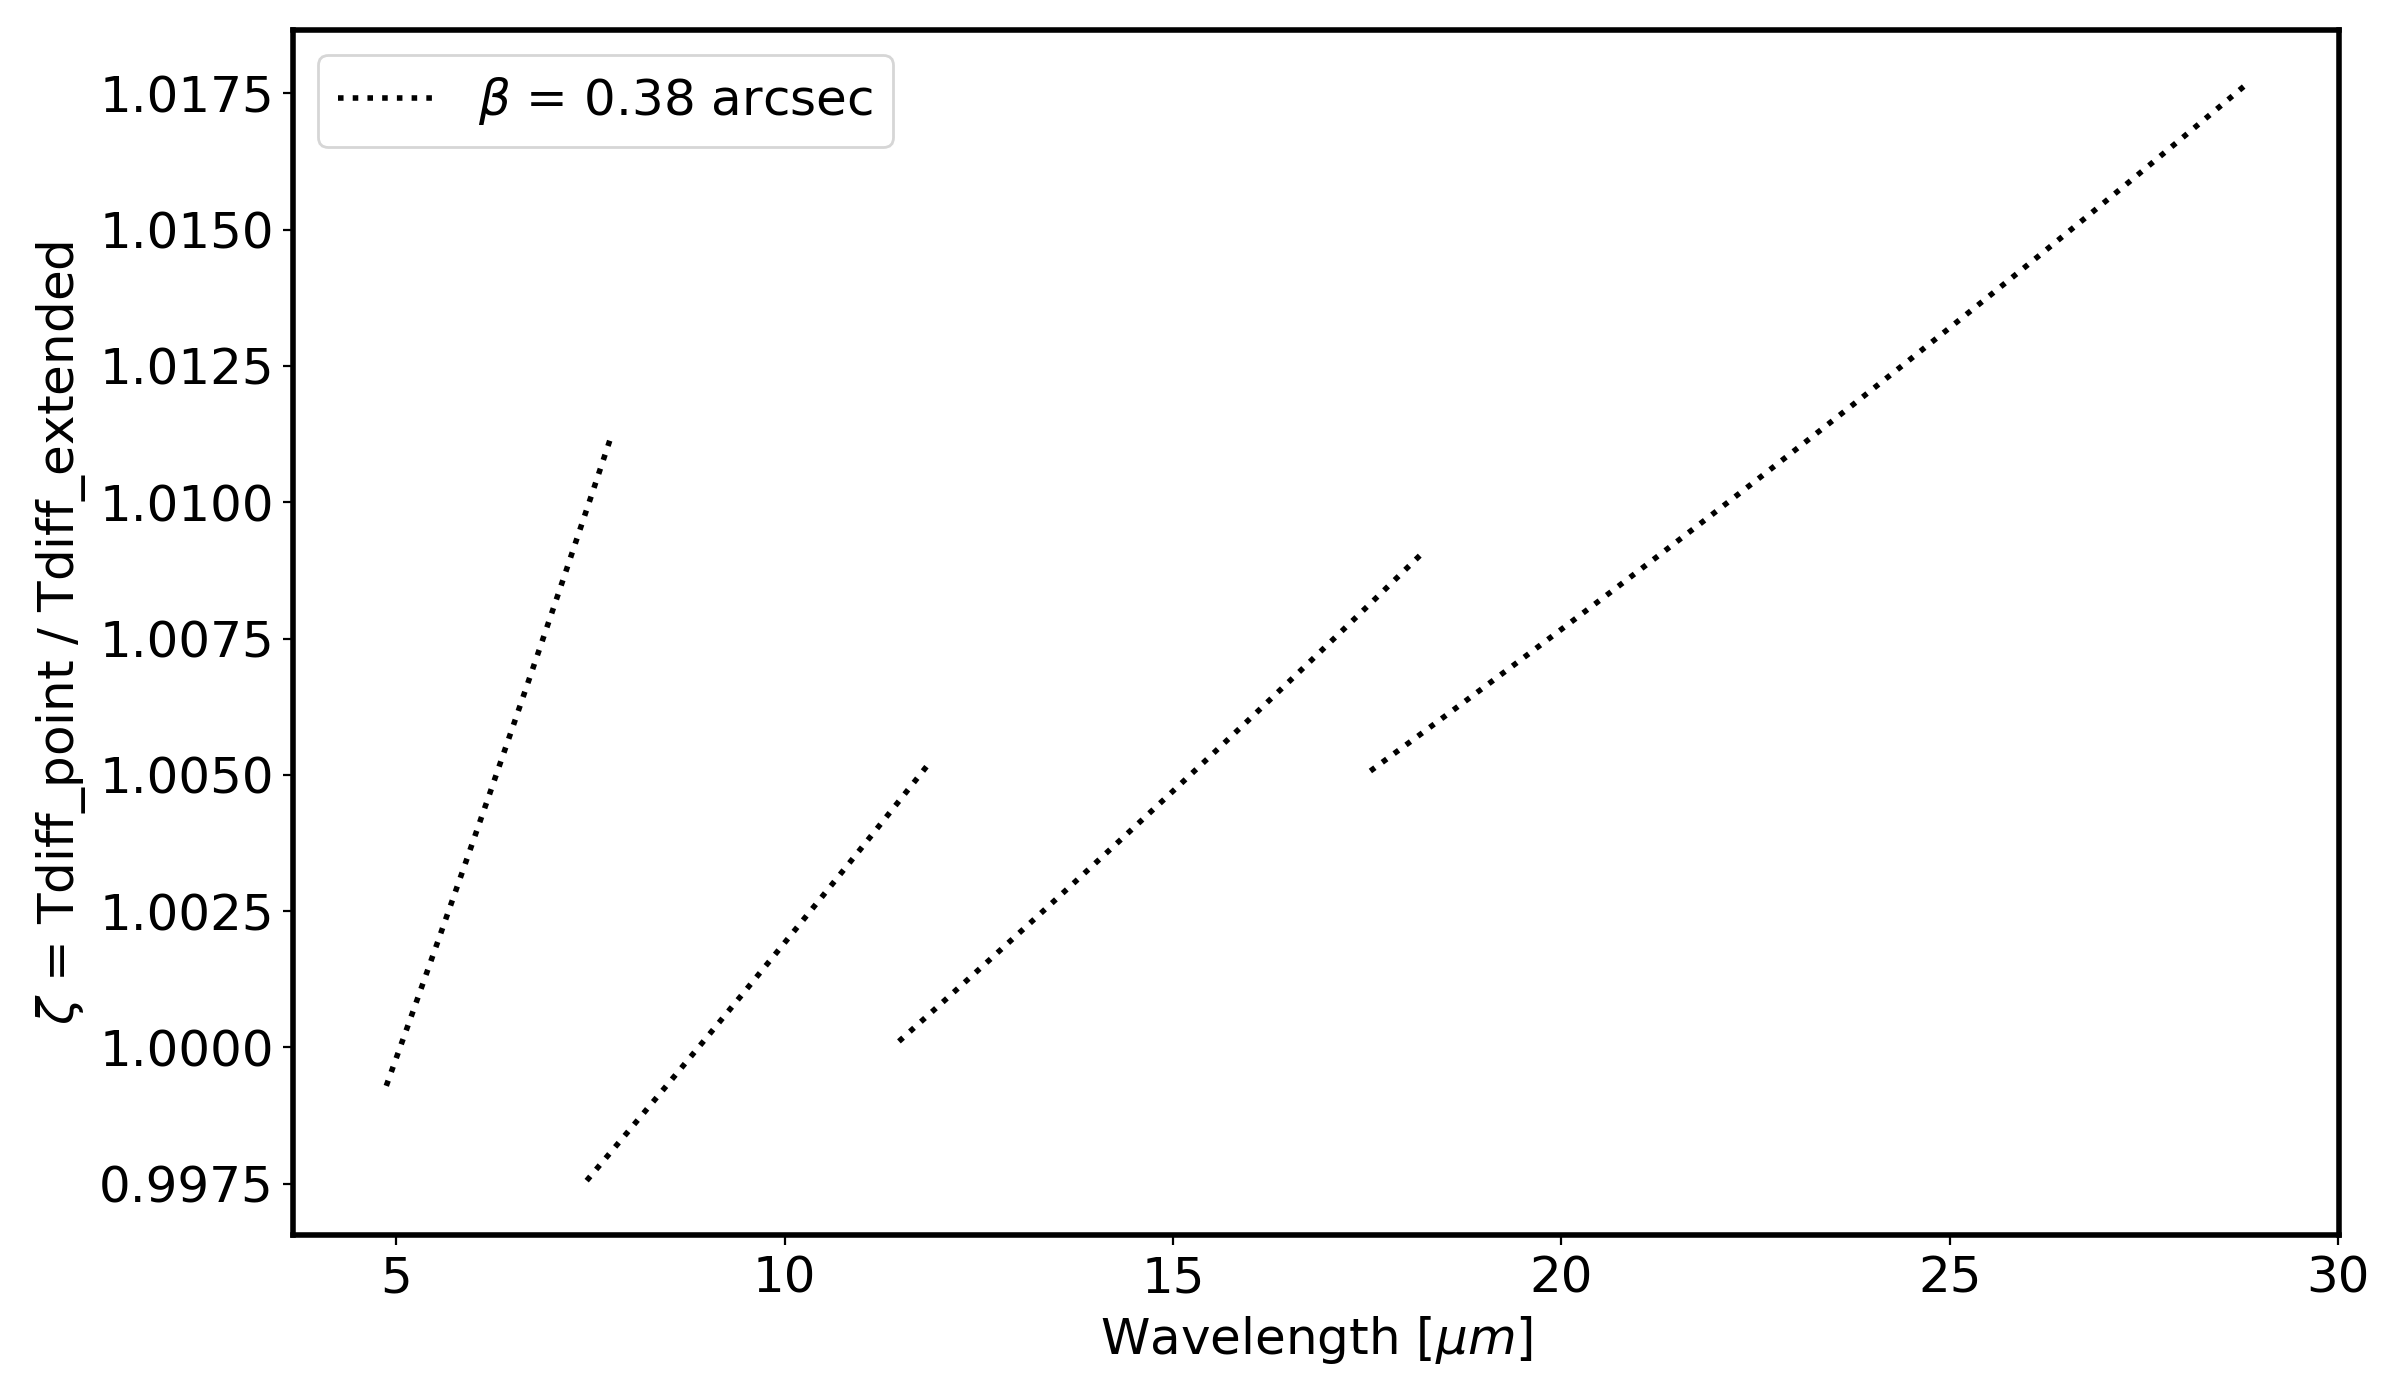

In [154]:
plt.figure(figsize=(12, 7))
for key in ['CH1', 'CH2', 'CH3', 'CH4']:
    plt.plot(wav_array[key], Tdiff_point[key], 'k', linestyle='dashed')
    plt.plot(wav_array[key], Tdiff_extended[key], 'k')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel(r'Transmission correction [%]')
legend_elements = [Line2D([0], [0], color='k', linestyle='dashed', label=r'Point source correction ($\beta$ = {} arcsec)'.format(np.round(beta, 2))),
                   Line2D([0], [0], color='k', linestyle='solid', label='Extended source correction')]
plt.legend(handles=legend_elements, fontsize=20)
plt.tight_layout()

plt.figure(figsize=(12, 7))
for key in ['CH1', 'CH2', 'CH3', 'CH4']:
    plt.plot(wav_array[key], Tdiff_point[key]/Tdiff_extended[key], 'k', linestyle='dotted')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel(r'$\zeta$ = Tdiff_point / Tdiff_extended')
legend_elements = [Line2D([0], [0], color='k', linestyle='dotted', label=r'$\beta$ = {} arcsec'.format(np.round(beta, 2)))]
plt.legend(handles=legend_elements)
plt.tight_layout()

<IPython.core.display.Javascript object>


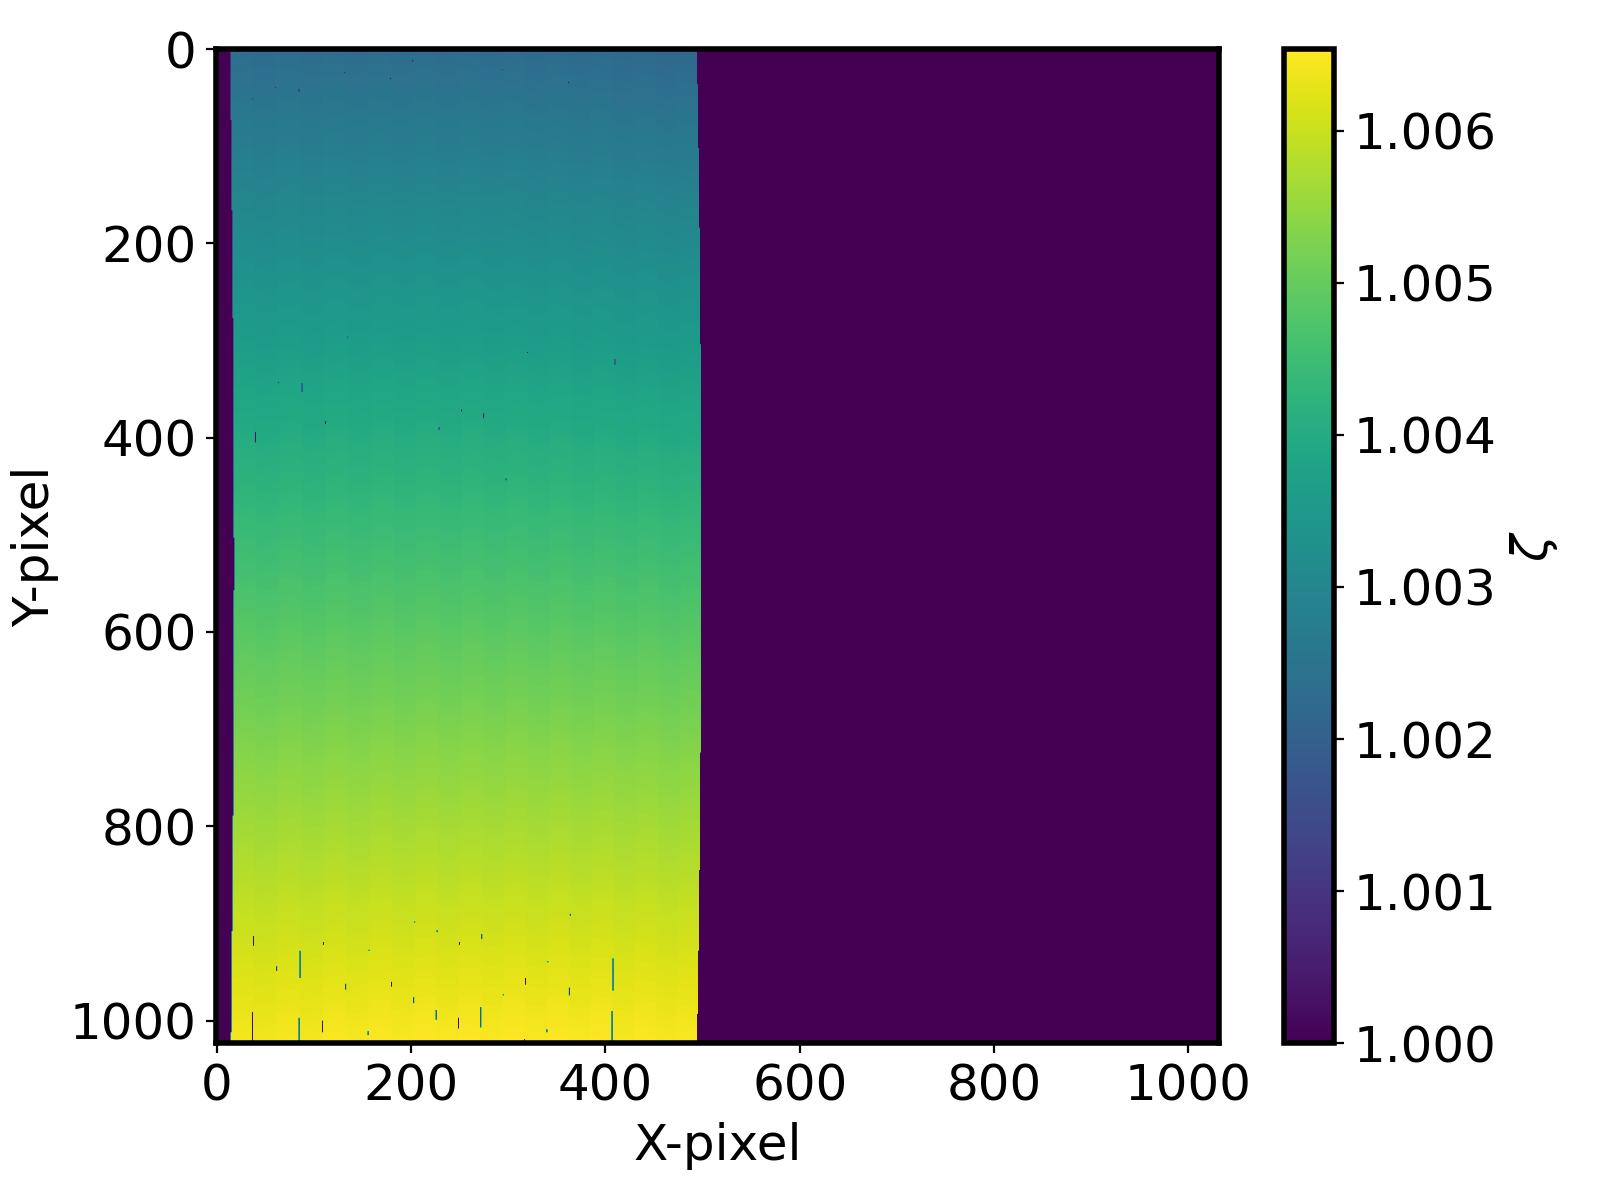

In [155]:
key = 'CH' + band[0]
ip_zeta = interp1d(wav_array[key], Tdiff_point[key]/Tdiff_extended[key], kind='linear')

zetaMap = np.ones(lambdaMap.shape)
sel = (sliceMap > 100*int(band[0])) & (sliceMap < 100*(int(band[0]) + 1))
zetaMap[sel] = ip_zeta(lambdaMap[sel])

plt.figure(figsize=(8, 6))
plt.imshow(zetaMap, vmin=zetaMap[zetaMap != 0].min(), vmax=zetaMap[zetaMap != 0].max())
clb = plt.colorbar()
clb.set_label(r'$\zeta$')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

In [156]:
# Apply correction to science and error signal
sci_img *= zetaMap
err_img *= zetaMap

# Determine wavelength correction due to source across-slice position $\beta$

<IPython.core.display.Javascript object>


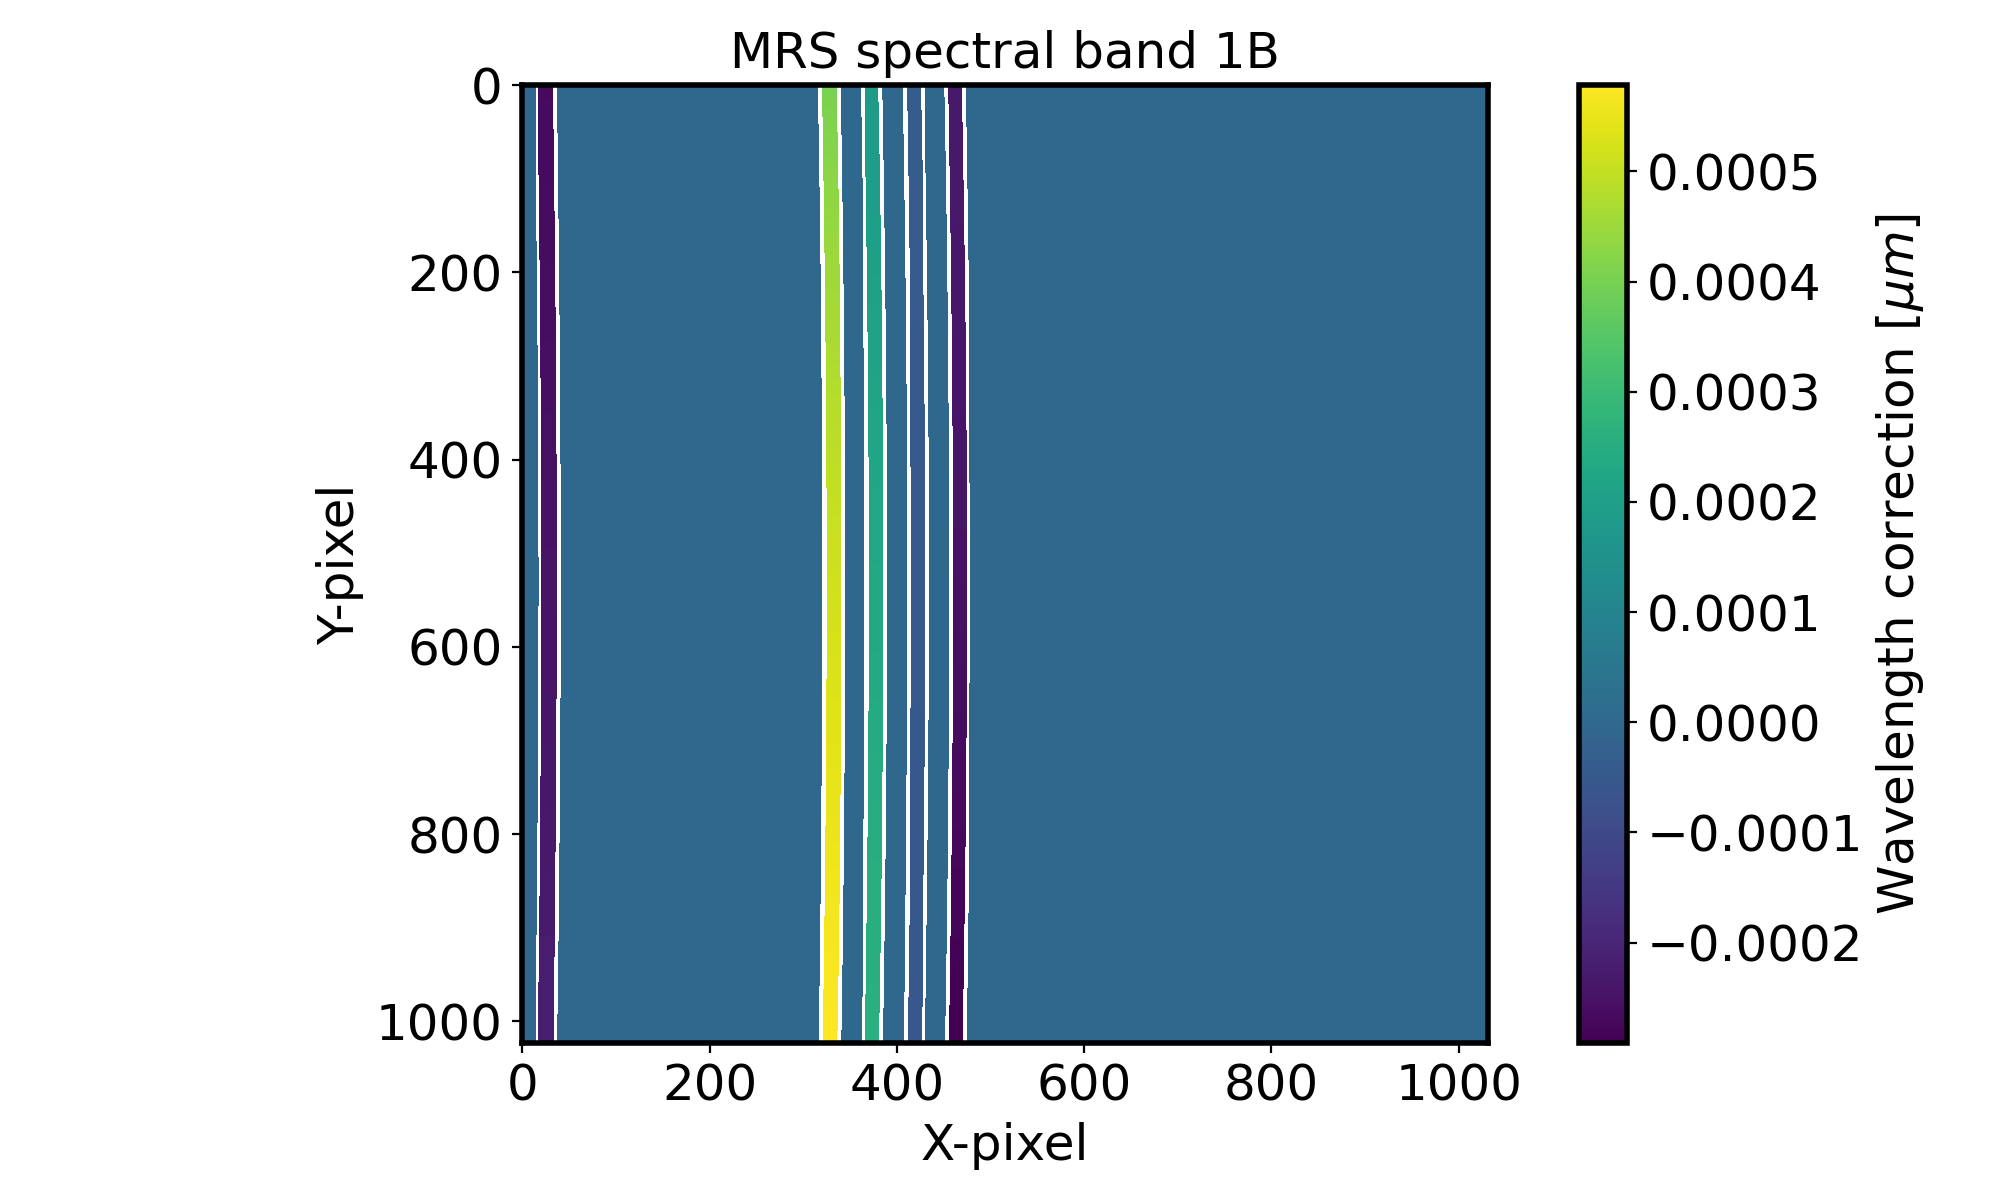

In [177]:
beta_center = np.mean(beta_centers2D_dict[band][20:-20])

# determine unique beta values for each slice
sel = np.where((sliceMap > 100*int(band[0])) & (sliceMap < 100*(int(band[0])+1)))
unique_betas = np.unique(betaMap[sel])

# find index of value nearest to beta center in the unique_betas array
idx = np.abs(unique_betas-beta_center).argmin() 
source_center_slice = idx+1

# find index of value nearest to beta center in the unique_betas array
beta_brightest_slice = unique_betas[idx]

# Point source offset from slice centre (-0.5 < tgtOffset < +0.5)
betaOffsetSlice0 = (beta_center-beta_brightest_slice)/d2cMaps['bdel'] 

# Define input data characteristics.
nSubBands = 3
optIndex = nSubBands * (int(band[0]) - 1) + (band_id_nr - 1)
betaSlice = beta_slice[optIndex]

# Compute wavelength correction map (based on MIRI-DD-00006-ATC issue 4)
# The correction is valid only for the two slices nearest to the brightest slice
wavcorr_across_slice = np.zeros((1024, 1032))
for islice in range(-2, 3):
    sel = (sliceMap == 100*int(band[0])+source_center_slice+islice)
    tgtWave = lambdaMap[sel]
    
    # Step 1. Find target offset from slice centre in beta direction'
    betaOff = betaOffsetSlice0 - islice

    # Step 2. Calculate Xslice
    xSlice = betaSlice / tgtWave
    xSliceref = betaSlice / ((lambmin+lambmax)/2.) # We define a reference xslice for the entire band to avoid jumps between beta_off values as a function of wavelength in Step 4.

    # Step 3. Derive scaled offset
    betaOff_scaled = betaOff * xSlice
    betaOff_scaled_ref = betaOff * xSliceref  # We define a reference betaOff_scaled_ref for the entire band to avoid jumps between beta_off values as a function of wavelength in Step 4.

    # Step 4. Find look-up table betaOff_LT values which bracket betaOFF_scaled
    nShiftValues = len(beta_off)
    betaSign = 1
    if (betaOff < 0.0):
        betaSign = -1
        betaOff_scaled = -1.0 * betaOff_scaled
    indexA = -1 # Index in look up table_WCORR_SHIFT 
    for j in range(nShiftValues):
        if (betaOff_scaled_ref < beta_off[j]):
            if (indexA == -1):
                indexA = j-1
    indexB = indexA + 1
    betaOff_LT_A = beta_off[indexA]
    betaOff_LT_B = beta_off[indexB]

    # Step 5. Find ds_min and ds_max
    betaFactor = (betaOff_scaled - betaOff_LT_A) / (betaOff_LT_B - betaOff_LT_A) 

    ds_minA = Delta_s_min_LT[indexA]
    ds_minB = Delta_s_min_LT[indexB]
    ds_min = ds_minA + betaFactor * (ds_minB - ds_minA)
    ds_min = betaSign * ds_min

    ds_maxA = Delta_s_max_LT[indexA]
    ds_maxB = Delta_s_max_LT[indexA]
    ds_max = ds_maxA + betaFactor * (ds_maxB - ds_maxA)
    ds_max = betaSign * ds_max

    # Step 6. Find ds by interpolation between ds_min and ds_max
    xSlice_min = x_slice_min_LT
    xSlice_max = x_slice_max_LT
    xFactor = (xSlice - xSlice_min) / (xSlice_max - xSlice_min)

    ds = ds_min + xFactor * (ds_max - ds_min)

    # Step 7. Convert ds to wavelength shift by intepolstion between SRP values
    w_min = wave_min[optIndex]
    w_max = wave_max[optIndex]
    wFactor = (tgtWave - w_min) / (w_max - w_min)

    srp = srp_min[optIndex] + wFactor * (srp_max[optIndex] - srp_min[optIndex])

    wavcorr_across_slice[sel] = ds * tgtWave / srp

# Plot wavelength correction map
plt.figure(figsize=(10, 6))
plt.imshow(wavcorr_across_slice)
clb = plt.colorbar()
clb.set_label('Wavelength correction [$\u03bc m$]')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

In [159]:
# Apply correction to wavelength map
lambdaMap += wavcorr_across_slice

# Load MRS PSF model in the 3D spectral cube and project it on the 2D detector

In [160]:
psf_fits_file = cdpDir+"MIRI_FM_{}_{}{}_PSF_07.02.00.fits".format(det_id, ch, band_id.upper())
psffits = fits.open(psf_fits_file)

# normalize and project PSF on 2D detector (normalization ensures that each cube slice of the model has a signal sum of 1)
psf_img = evaluate_psf_cdp(psffits, d2cMaps, source_center=[np.mean(alpha_centers2D_dict[band][20:-20]), np.mean(beta_centers2D_dict[band][20:-20])], norm=True)

# close fits file
psffits.close()

2022-04-13 23:25:52,355 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_20205/1460910706.py:2: ResourceWarning: unclosed file <_io.FileIO name='./miri_devel/cdp_data/MIRI_FM_MIRIFUSHORT_1MEDIUM_PSF_07.02.00.fits' mode='rb' closefd=True>
  psffits = fits.open(psf_fits_file)



Normalizing PSF (divide by sum of all spaxel values)
DONE


<IPython.core.display.Javascript object>


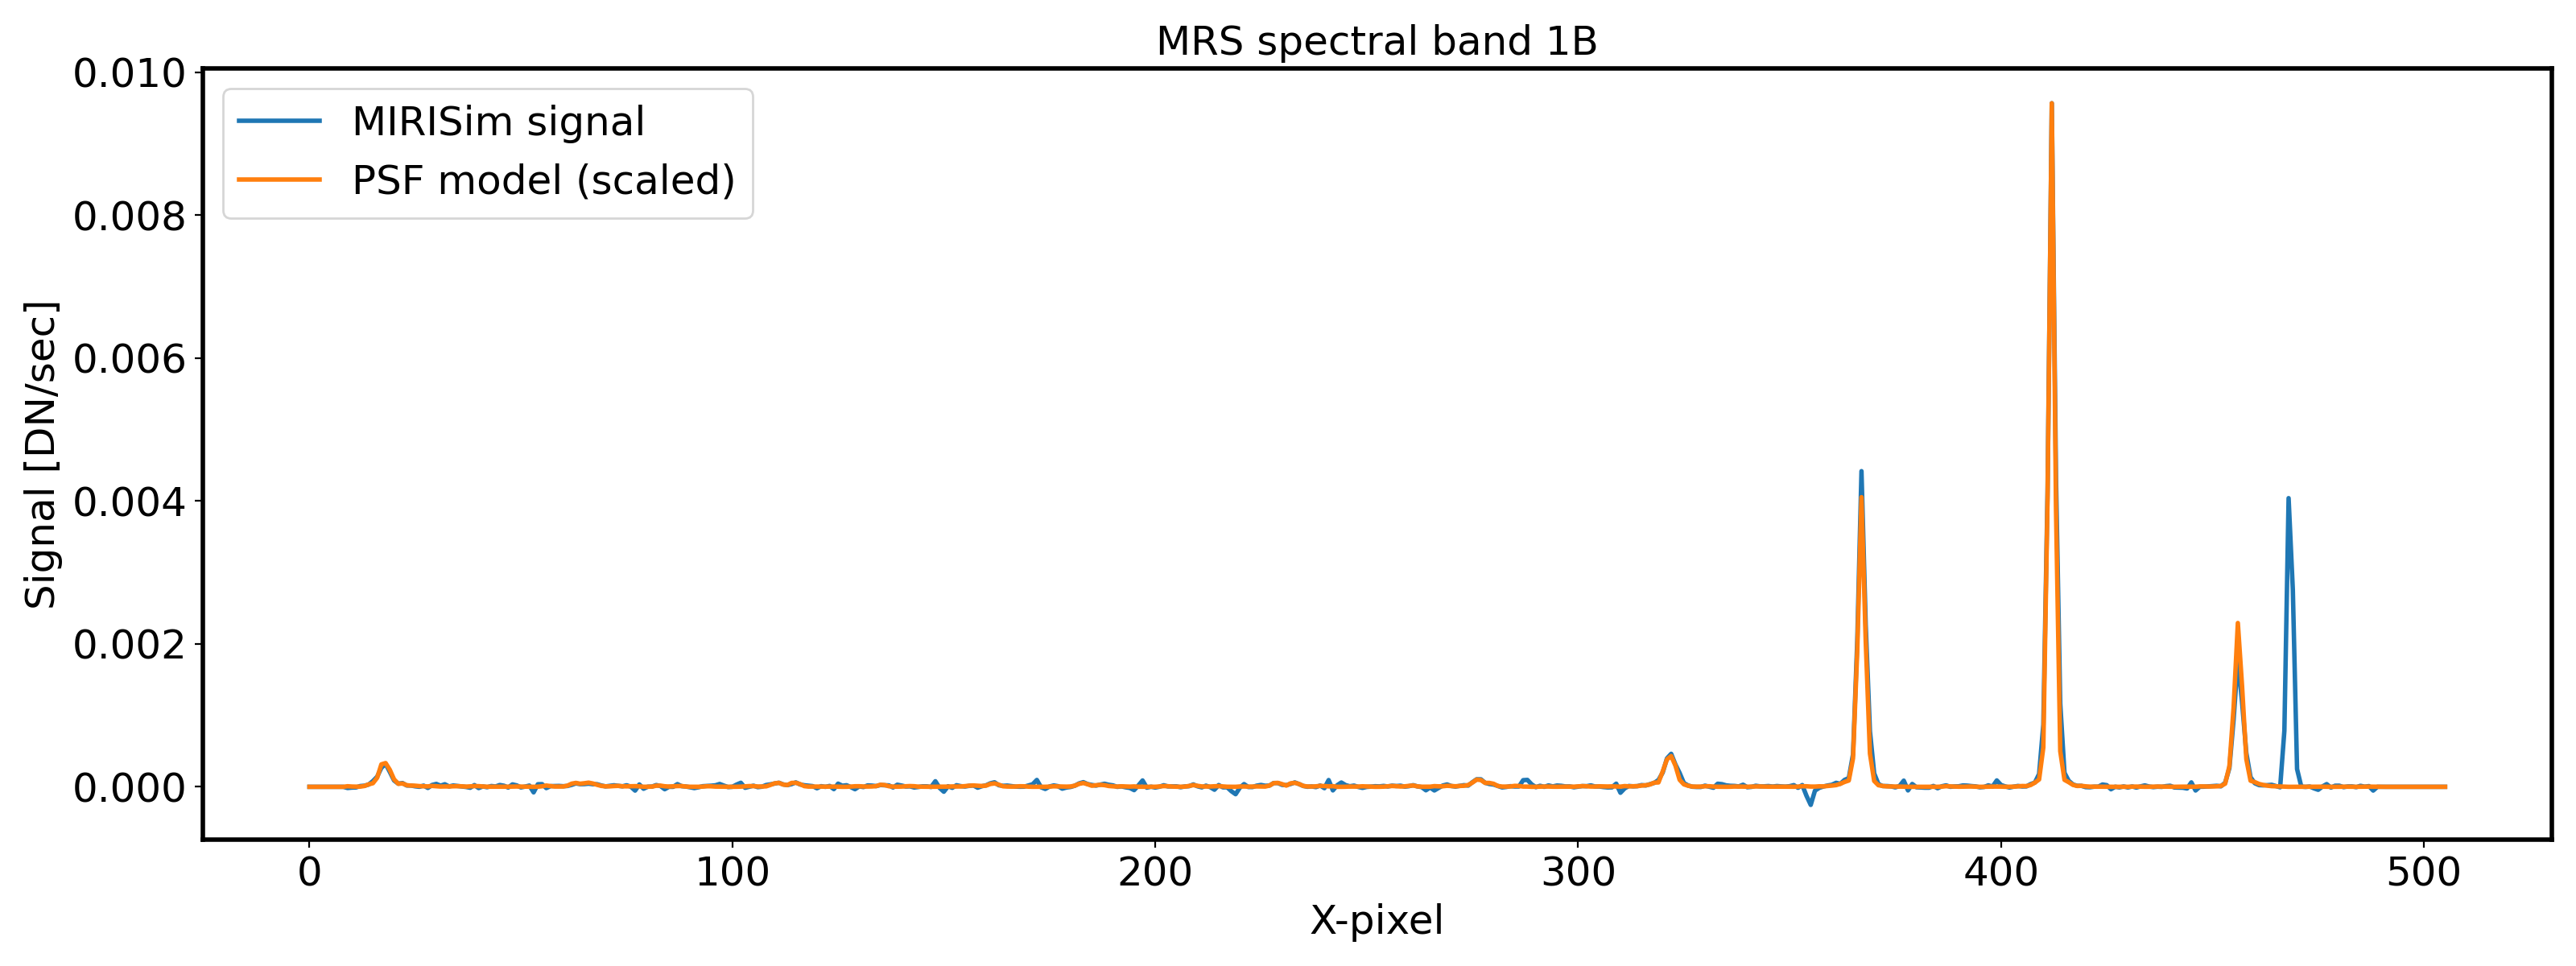

In [161]:
# Diagnostic plot to show how well the projected PSF matches the data
# For low SNR observations this will likely not be very useful
plt.close('all')
plt.figure(figsize=(16, 6))
if band[0] in ['1', '4']:
    plt.plot(sci_img[512, 10:516], label='MIRISim signal')
    scale_factor = (sci_img[512, 10:516][~np.isnan(sci_img[512, 10:516])].max()/psf_img[512, 10:516].max())
    plt.plot(psf_img[512, 10:516]*scale_factor, label='PSF model (scaled)')
elif band[0] in ['2', '3']:
    plt.plot(sci_img[512, 516:-10], label='MIRISim signal')
    scale_factor = (sci_img[512, 516:-10][~np.isnan(sci_img[512, 516:-10])].max()/psf_img[512, 516:-10].max())
    plt.plot(psf_img[512, 516:-10]*scale_factor, label='PSF model (scaled)')
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

In [162]:
# Determine optimal pixel weights for detector-based spectral extraction
weight_map = psf_img**2 / (err_img)**2

In [190]:
# Wavelength array used for the detector-based spectral extraction
# The grid step is approximately half the smallest spectral size in each band (due to the MRS distortion and slice curvature, different pixels contribute to each bin)
wav_array = {'1A': np.arange(4.9, 5.74, 0.0005), '1B': np.arange(5.67, 6.6, 0.0008), '1C': np.arange(6.45, 7.5, 0.001),
             '2A': np.arange(7.477, 8.765, 0.0014), '2B': np.arange(8.711, 10.228, 0.0017), '2C': np.arange(10.017, 11.753, 0.002),
             '3A': np.arange(11.481, 13.441, 0.0023), '3B': np.arange(13.319, 15.592, 0.0026), '3C': np.arange(15.4, 18.072, 0.0030),
             '4A': np.arange(17.651, 20.938, 0.0036), '4B': np.arange(20.417, 24.22, 0.0042), '4C': np.arange(23.884, 28.329, 0.0048)}
nwavs = len(wav_array[band])

# Evaluate smallest distortion solution on the 2D detector (largest slice transmission of 90%)
slice_transmission = '90pc'
d2cMaps = d2cMapping(band, d2cDir, slice_transmission=slice_transmission, fileversion="8B.05.02")
lambdaMap = d2cMaps['lambdaMap']
lambdas = lambdaMap[np.nonzero(lambdaMap)].flatten()

# Need approximate number of pixels contributing to each spectral bin
# This is because only one pixel is used for each detector column --> we want to avoid sampling issues
if band[0] in ['1', '2']:
    if slice_transmission == '90pc':
        npix = 380
    elif slice_transmission == '10pc':
        npix = 500
elif band[0] in ['3', '4']:
    npix = 380
k = np.arange(npix)

# Define pixel grid
X, Y = np.meshgrid(np.arange(1032), np.arange(1024))
X_flat = X[np.nonzero(lambdaMap)].flatten()
Y_flat = Y[np.nonzero(lambdaMap)].flatten()

In [207]:
# Omit NaNs from analysis
nan_idx = ~np.isnan(sci_img)

<IPython.core.display.Javascript object>


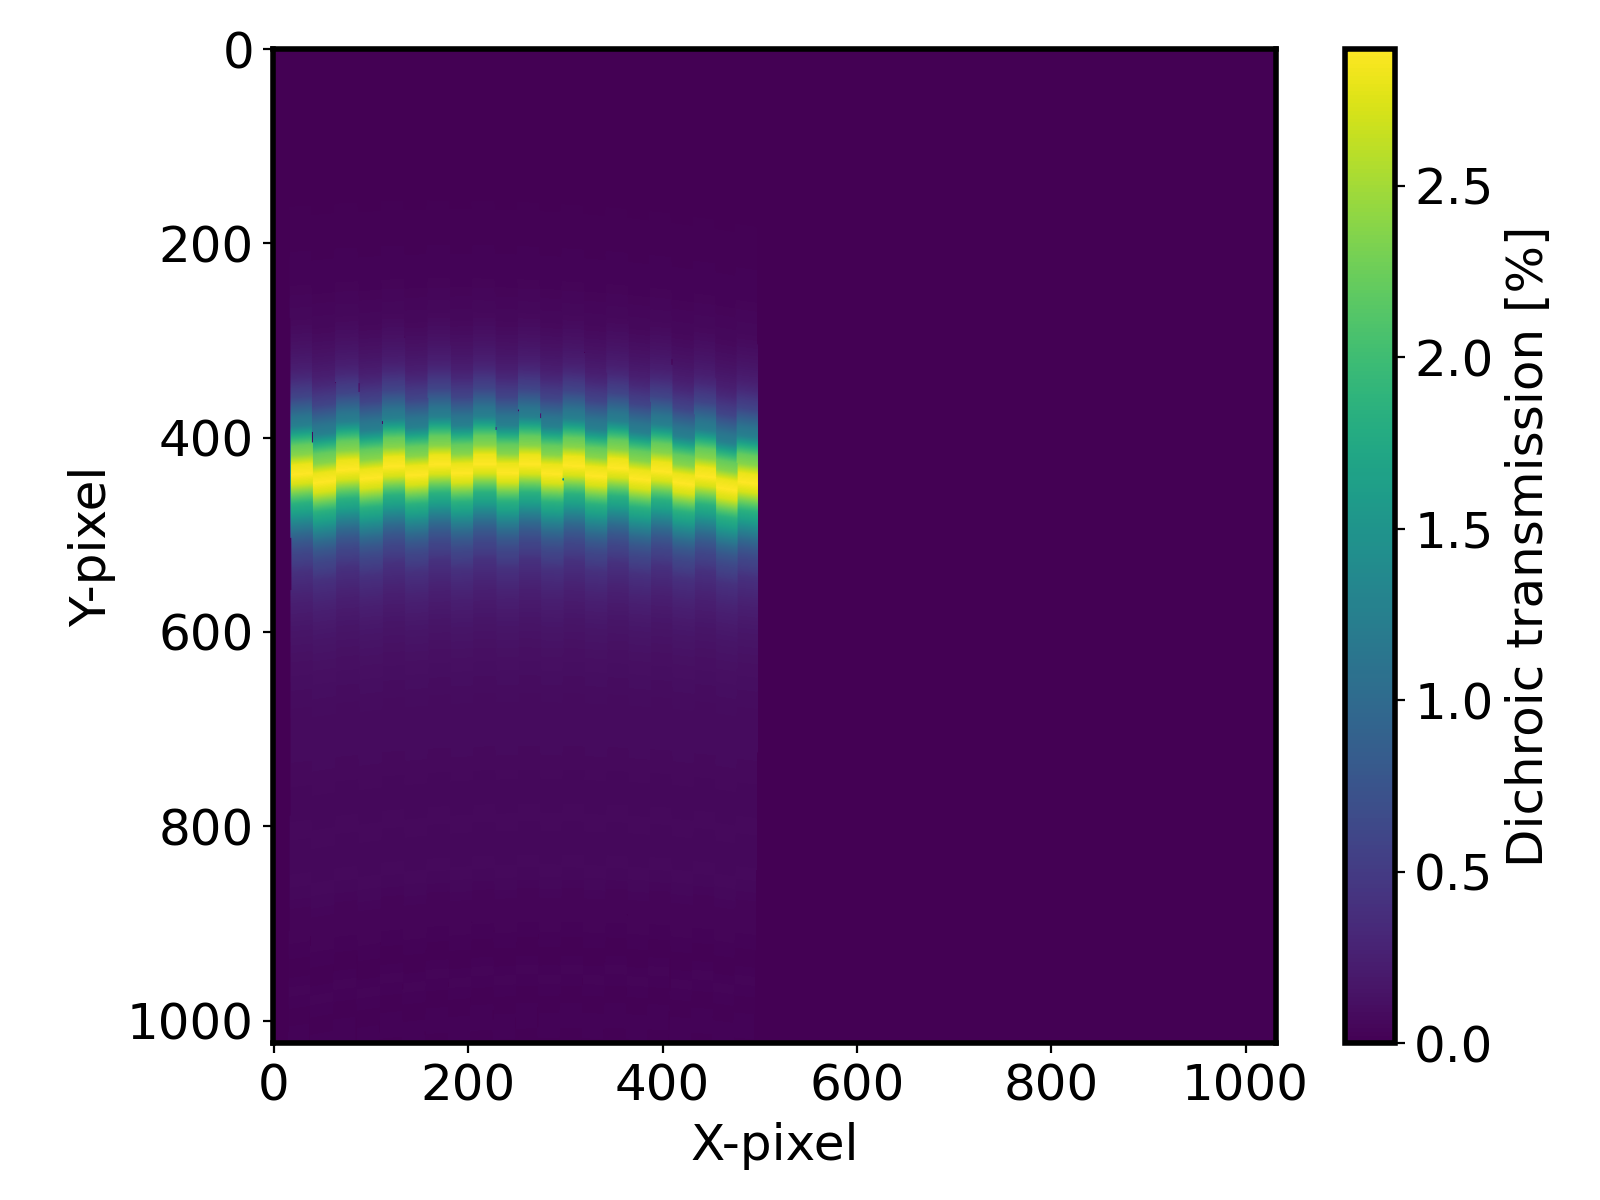

<IPython.core.display.Javascript object>


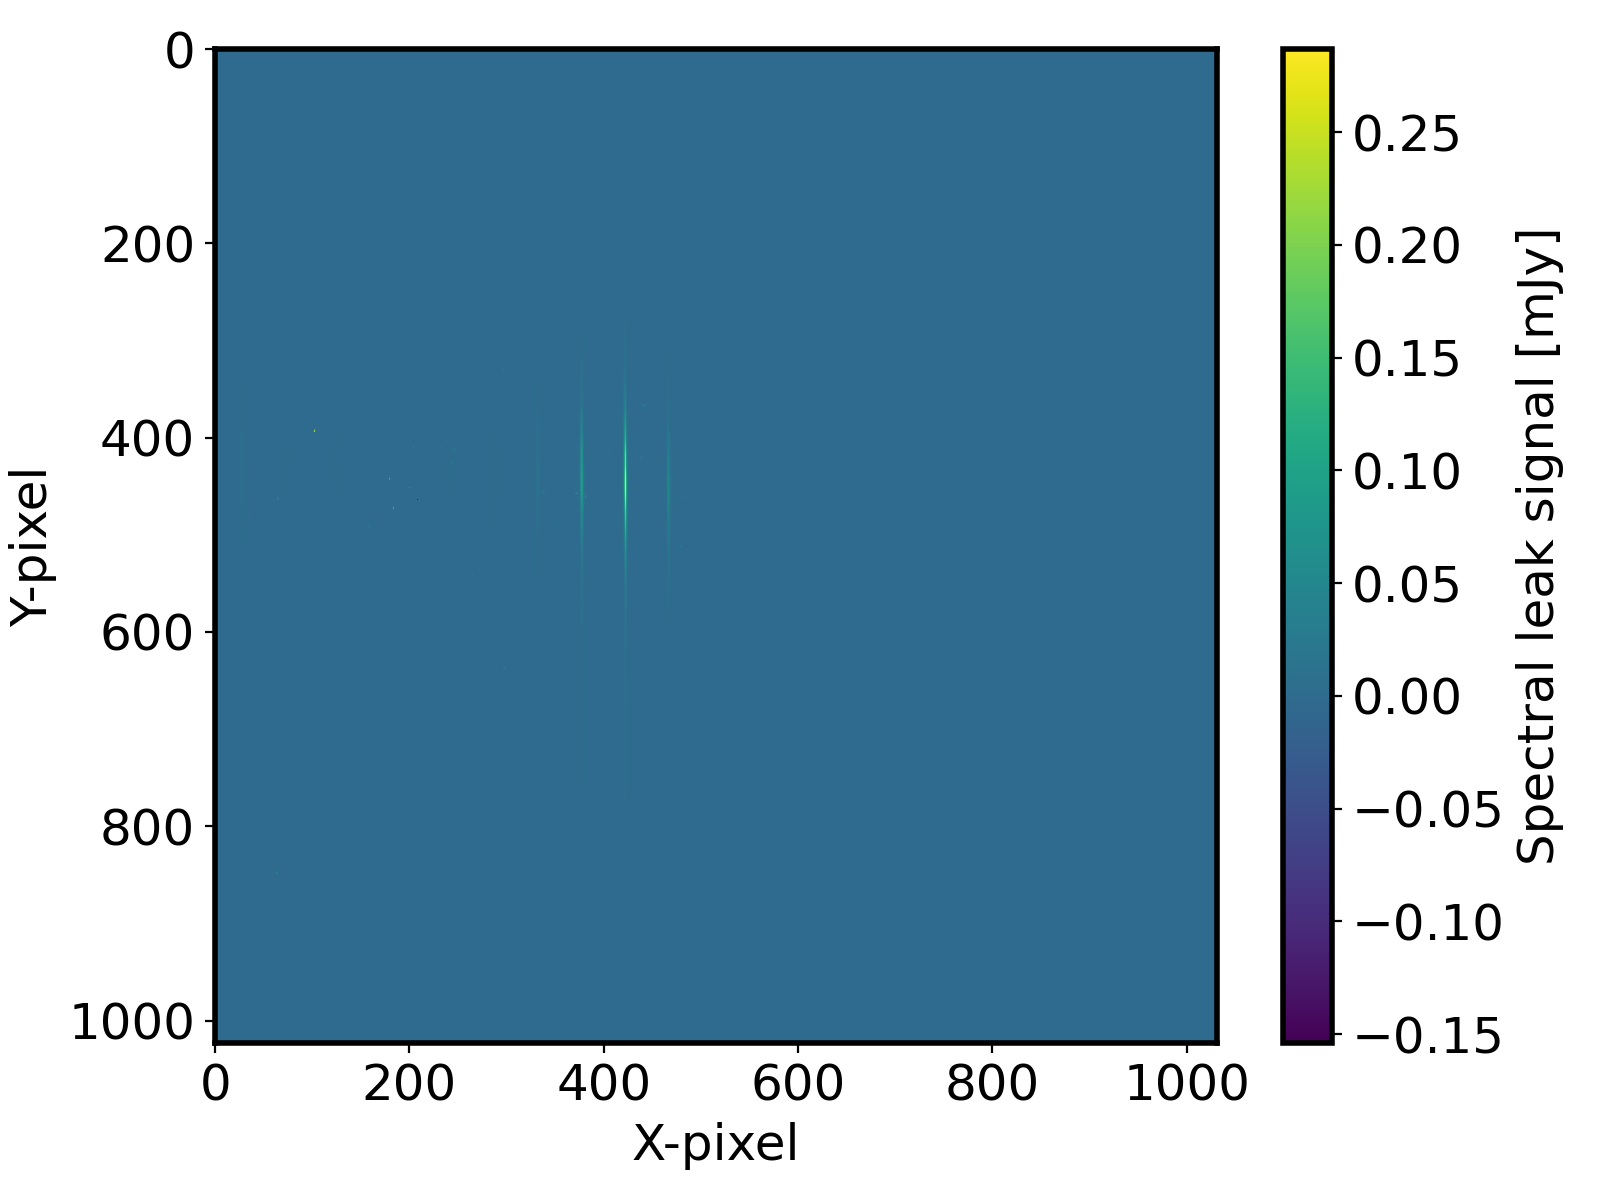

In [208]:
# Diffraction grating second order spectral leak contribution
if band == '1B':
    
    np.save('spectral_leak_transmission.npy', sys_transm_img)
    
    plt.close('all')
    plt.figure(figsize=(8, 6))
    plt.imshow(sys_transm_img*100.)
    clb = plt.colorbar()
    clb.set_label('Dichroic transmission [%]')
    plt.xlabel('X-pixel')
    plt.ylabel('Y-pixel')
    plt.tight_layout()
    
    # Compute spectral leak signal from band 1B and update the error map
    spectral_leak_sci_img = sci_img*sys_transm_img
    spectral_leak_err_img = err_img*sys_transm_img
    
    plt.figure(figsize=(8, 6))
    plt.imshow(spectral_leak_sci_img*1000)
    clb = plt.colorbar()
    clb.set_label('Spectral leak signal [mJy]')
    plt.xlabel('X-pixel')
    plt.ylabel('Y-pixel')
    plt.tight_layout()
    
    # Redetermine optimal pixel weights for detector-based spectral extraction
    spectral_leak_weight_map = psf_img**2 / (spectral_leak_err_img)**2
    
    # Initialize placeholder
    spectral_leak_spectrum = np.zeros(nwavs)

In [209]:
# Perform detector-based spectral extraction
isolambda_spec_optimal[band] = np.zeros(nwavs)

for i in range(nwavs):
    # determine pixels contributing to spectral bin
    test_img = np.zeros((1024, 1032))
    idxs = np.argsort(np.abs(lambdas-wav_array[band][i]))[k]
    test_img[Y_flat[idxs], X_flat[idxs]] = 1
    
    # ascertain that only one pixel is selected per detector column
    outliers = np.where(np.sum(test_img, axis=0) == 2)[0]

    for col in outliers:
        Y_ = np.argsort(np.abs(lambdaMap[:, col] - wav_array[band][i]))[1]
        test_img[Y_, col] = 0
    
    # plot meant for debugging !!!ONLY USE AT A SINGLE WAVELENGTH!!!
    # plt.figure()
    # plt.imshow(test_img,aspect=0.5)
    # plt.tight_layout()

    # spectral extraction
    sel_valid = (test_img == 1) & nan_idx
    isolambda_spec_optimal[band][i] = np.sum(weight_map[sel_valid] * sci_img[sel_valid] / psf_img[sel_valid]) / np.sum(weight_map[sel_valid])
    
    if band == '1B':
        # Estimate diffraction grating second order spectral leak contribution
        spectral_leak_spectrum[i] = np.sum(spectral_leak_weight_map[sel_valid] * spectral_leak_sci_img[sel_valid] / psf_img[sel_valid]) / np.sum(spectral_leak_weight_map[sel_valid])

<IPython.core.display.Javascript object>


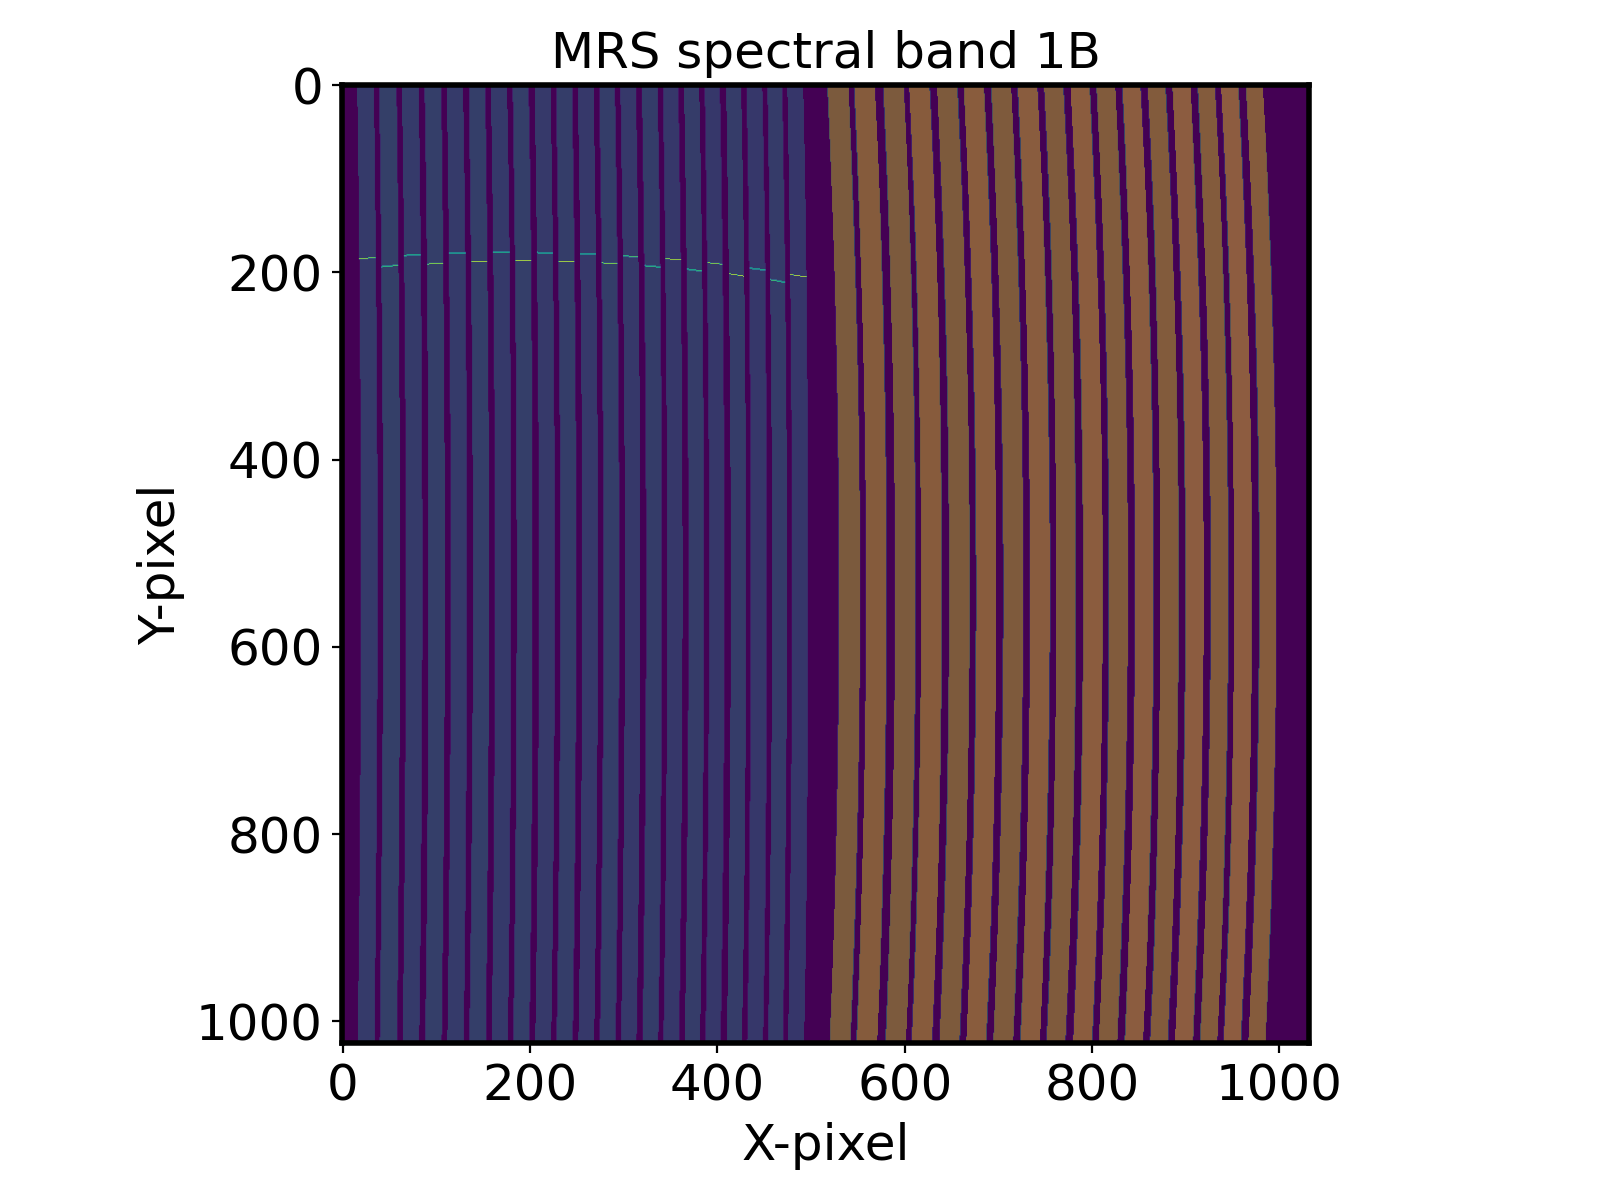

In [213]:
# debugging spectral bins

i = 200
# determine pixels contributing to spectral bin
test_img = np.zeros((1024, 1032))
idxs = np.argsort(np.abs(lambdas-wav_array[band][i]))[k]
test_img[Y_flat[idxs], X_flat[idxs]] = 1

# ascertain that only one pixel is selected per detector column
outliers = np.where(np.sum(test_img, axis=0) == 2)[0]

for col in outliers:
    Y_ = np.argsort(np.abs(lambdaMap[:, col]-wav_array[band][i]))[1]
    test_img[Y_, col] = 0

plt.figure(figsize=(8, 6))
plt.imshow(test_img)
plt.imshow(d2cMaps['sliceMap'], alpha=0.4)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

<IPython.core.display.Javascript object>


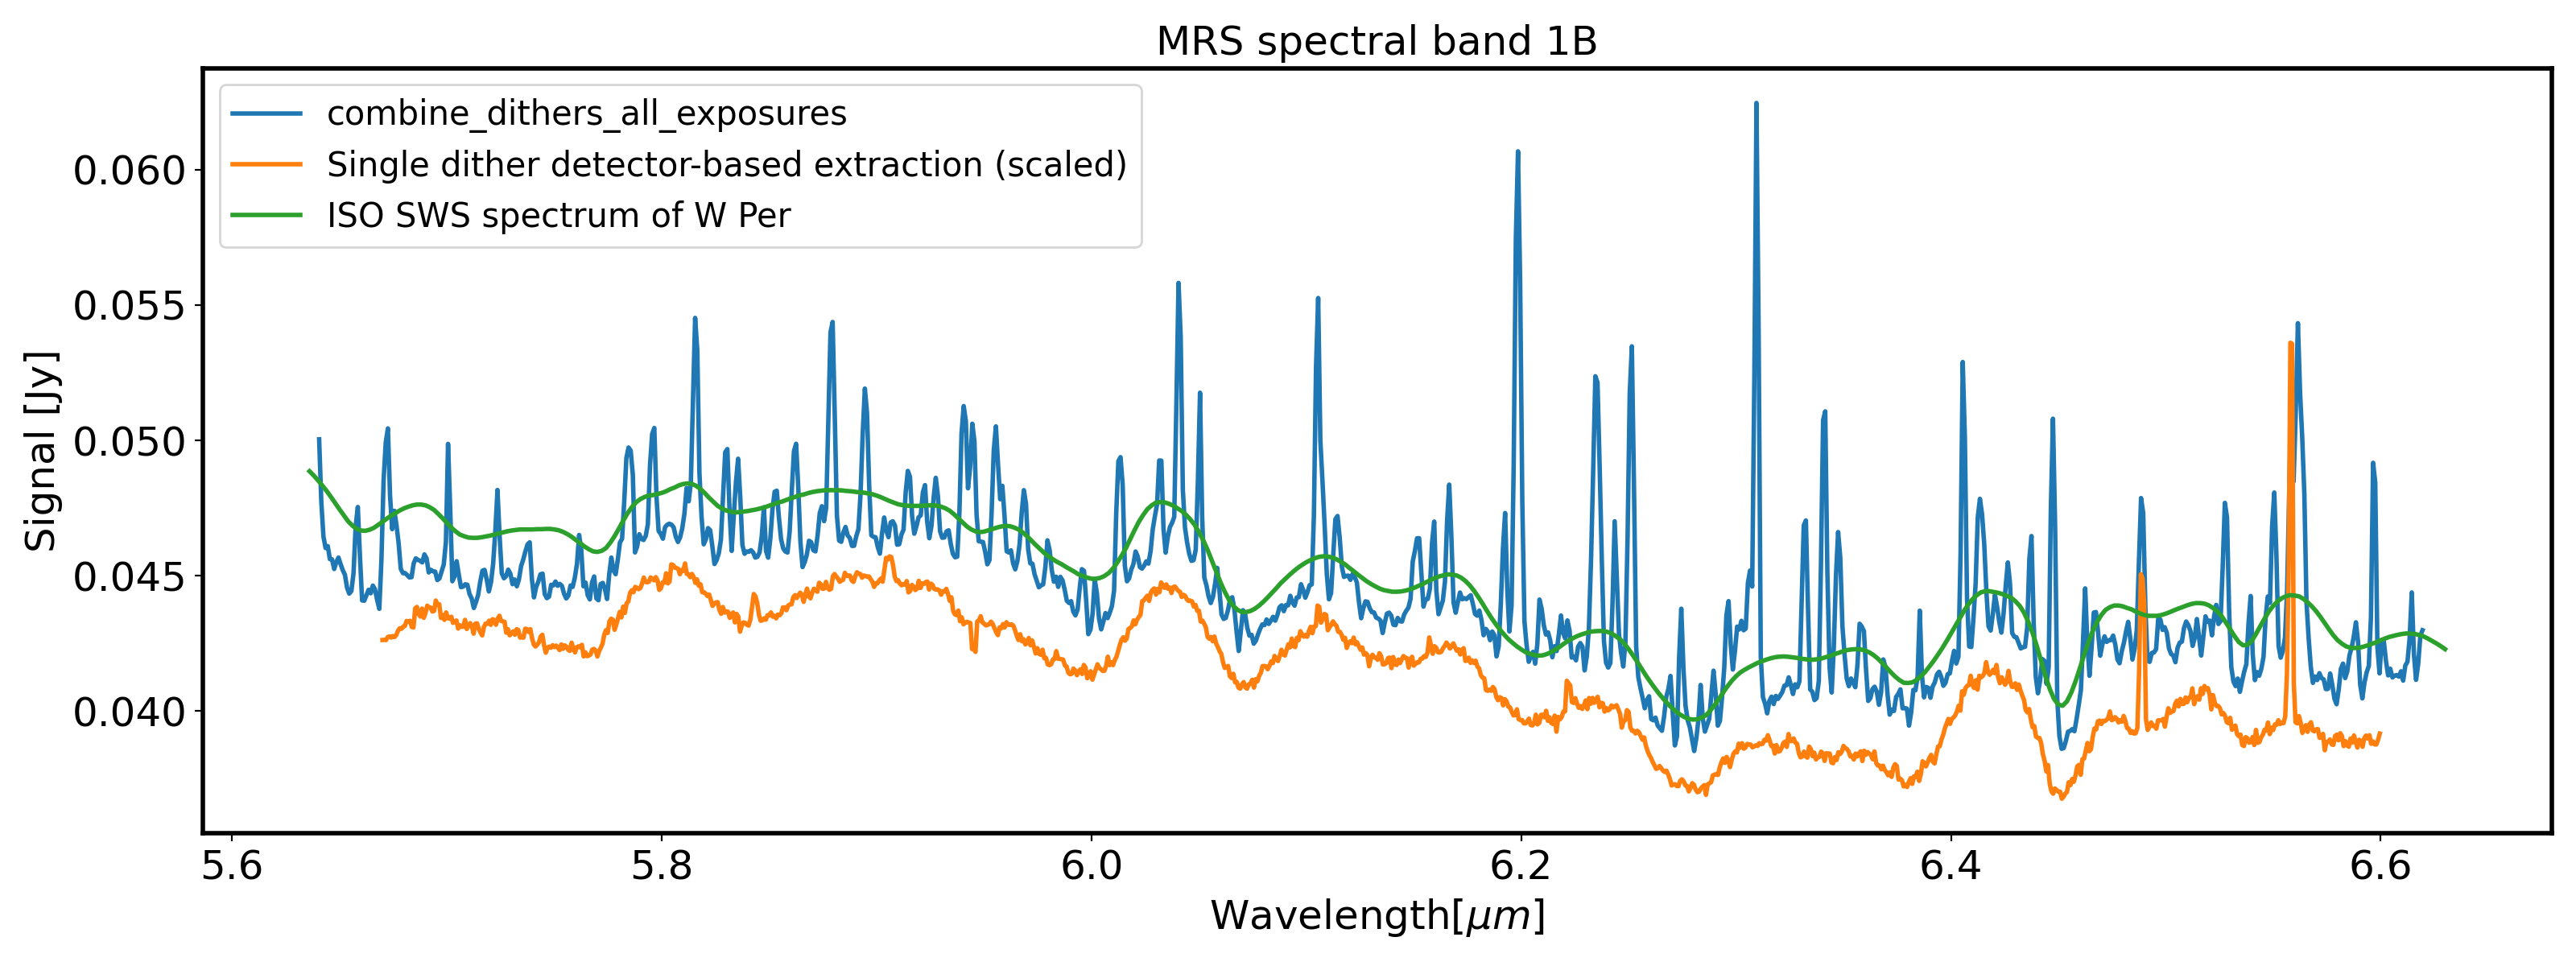

<IPython.core.display.Javascript object>


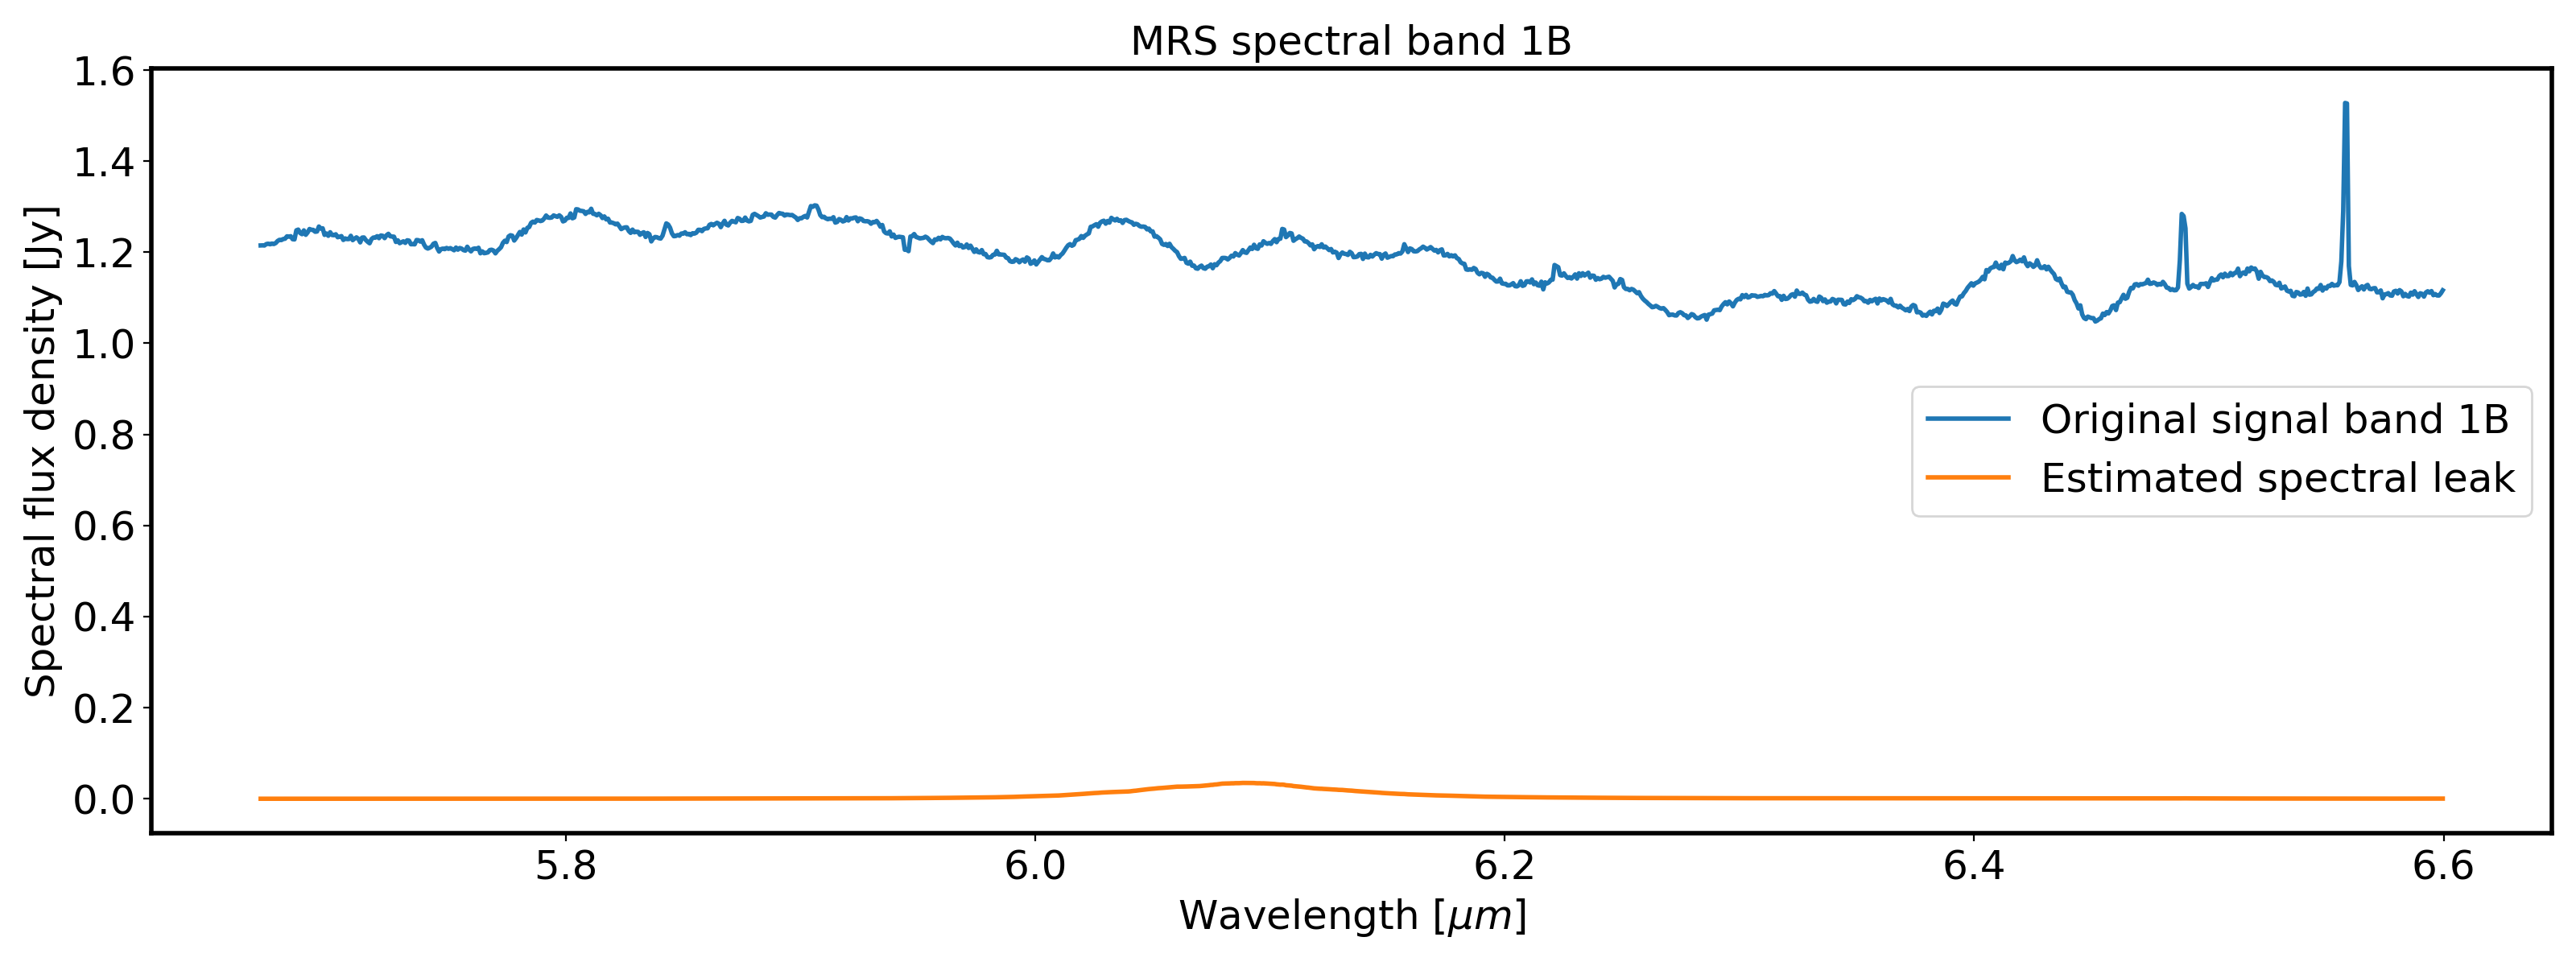

In [214]:
# Compare resulting extracted spectrum to result from JWST-pipeline-reconstructed spectrum and original ISO spectrum
# Disclaimer: Due to flux conservation issues in MIRISim, the  MIRISim MRS PSF is broader than the MRS PSF CDP model. 
# This results on the detector-based spectrum having a significantly higher spectral baseline.

# JWST pipeline result
hdu = fits.open('combine_dithers_all_exposures_ch{}-{}_x1d.fits'.format(ch, band_id))
wav = hdu[1].data['WAVELENGTH']
flux = hdu[1].data['FLUX']
hdu.close()

# Original ISO spectrum
W_Per_hdu = fits.open('W_Per_spectrum_sws.fit')
wav_WPer = W_Per_hdu[0].data[:, 0]
flux_WPer = W_Per_hdu[0].data[:, 1]
sel_WPer = (wav_WPer > lambmin) & (wav_WPer < lambmax)
W_Per_hdu.close()

# Plot
if band in ['1A', '1B', '1C']:
    fudge_factor = 28.5
elif band in ['2A', '2B', '2C']:
    fudge_factor = 45
plt.close('all')
plt.figure(figsize=(16, 6))
plt.plot(wav, flux, label='combine_dithers_all_exposures')
plt.plot(wav_array[band], isolambda_spec_optimal[band]/fudge_factor, label='Single dither detector-based extraction (scaled)')
plt.plot(wav_WPer[sel_WPer], flux_WPer[sel_WPer]/1000., label='ISO SWS spectrum of W Per')
plt.xlabel(r'Wavelength' u'[$\u03bc m$]')
plt.ylabel(r'Signal [Jy]')
plt.title('MRS spectral band {}'.format(band))
plt.legend(fontsize=15)
plt.tight_layout()

if band == '1B':
    plt.figure(figsize=(16, 6))
    plt.plot(wav_array[band], isolambda_spec_optimal[band], label='Original signal band 1B')
    plt.plot(wav_array[band], spectral_leak_spectrum, label='Estimated spectral leak')
    plt.xlabel('Wavelength [$\u03bc m$]')
    plt.ylabel('Spectral flux density [Jy]')
    plt.title('MRS spectral band 1B')
    plt.legend()
    plt.tight_layout()

## Correct for spectral leak if MRS band is set to 3A
## CAUTION: In order for the following cell to work, the user must have run this notebook already once for band 1B.

In [212]:
if band == '3A':
    spectral_leak_corr_band3A = isolambda_spec_optimal[band]-spectral_leak_spectrum

# THE END

## Still to do:
- Loop the notebook over all dither positions and average the resulting spectra. The reason why we may not want to use all four dithers in one go (i.e. to run the detector based extraction only once) is because we will likely find variations in the PSF as a function of which slice gets illuminated on the detector (think incoming cone angle and detector-scattered light).
- Consider updating current centroiding algorithm to use the cross-correlation method of the SDSS MANGA pipeline.

## About this notebook
**Author:** Ioannis (Yannis) Argyriou, Post-Doctoral Researcher, Institute of Astronomy, KU Leuven, Belgium  
**Date:** 2022-01-08

***

[Top of Page](#top)